In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

%matplotlib inline
sns.set(color_codes=True)


# Question 1: Propensity score matching

### Task 1. Naive Analysis
In this analysis being an EPFL student doesn't really help. We will try to immitate the analysis of a naive researcher for the specific dataset. The dataset represents the NSW training programm results. This research was conducted to show the efficiency of the training programm in terms of income after the end of it. The people are being divided in two categories: The ones that participated in the programme (treat == 1) and the others that did not (treated == 0). These two categories form two groups the:
   
    1. The treated group
    2. The control group
    
Thus the dataset incudes some features useful for the analysis as the gender, the race, the income after the end of the programme referring to these groups.

In order for our analysis to start, we loaded the dataset at first. And we made a copy of that in order to manipulate it as we want.

In [43]:
lalonde_raw = pd.read_csv('./lalonde.csv')
lalonde_data = lalonde_raw.copy()
lalonde_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Our naive analysis starts with the seperation of the dataset in two dataframes, each of which includes the seperate groups. On the one hand there are the trained and on the other the people that they didn't attend the programme.

In [44]:
treated = lalonde_data.loc[lalonde_data['treat'] == 1] #People that attained the programme
control = lalonde_data.loc[lalonde_data['treat'] == 0] #People that didn't attain the programme

After that step we thought that the easiest and most naive way to extract some statistical information for our dataset would be to use the built in function of pandas, which calculates some statistical features of the dataframe provided. So we apply this function to the seperate datasets just to see if there are some obvious inferences.

In [45]:
treated.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [46]:
control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


As our analysis is superficial we will focus our attempts of extracting useful information about the result of the programm only on specific features. This is why we decided that we will stick only with the income level after the completition of the programme. Thus we filtered the two datasets to include just this attribute.

In [47]:
treated.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [48]:
control.re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

With the statistical information that we have extracted we can now infer some relations and notice differences between the two groups.

First of all we notice, that the dataset is not balanced and this should trigger us some thoughts about the detailed analysis later.. But in general we notice that the number of treated people is almost half of the people that were belonging to the control group. Leaving that behind and not taking into consideration that the statistics might be biased someone can observe the following things:

1. <b>Mean:</b> For the treated group we can notice, that the mean value of the re78 is <b>6349</b> whereas for the control group is a higher <b>6984</b>. This difference of <b>635</b> shows that the people that didn't attend the training programme achieved higher income. Something that is counter-intuitive according the target of the programme.

2. <b>Min:</b> We can also observe that in both categories there were trained people,who continued to stay unemployed and having zero income. And of course people, who hadn't participated in the programme and they didn't have income in any case.

3. <b>Percentiles:</b> From the percentiles we can observe that apart from the first percentile where the income of the treated group is higher in every other percentile the income of the non-treated(control group) is much greater. 

4. <b>Max:</b> The maximum income of the two groups indicates that the maximum income indeed comes from the treated group and the difference is quite big as the trained group has 3 times higher income than the untrained (<b>60307 vs 25564</b>).

Given that the numbers (statistical analysis) don't give us a solid intuition and eventually a result of which group performed better in terms of income after the end of the programme,we decided to visualize also the 2 distributions in order to have a better picture.

In [49]:
def distr_comp(df1,df2,col,title,xl,yl):
    plt.figure(figsize=(15,6))
    ax = sns.distplot(treated[col], hist=True, label='treated');
    ax = sns.distplot(control[col], hist=True, label='control')

    ax.set(title=title,xlabel=xl, ylabel=yl)
    plt.legend()
    plt.show()

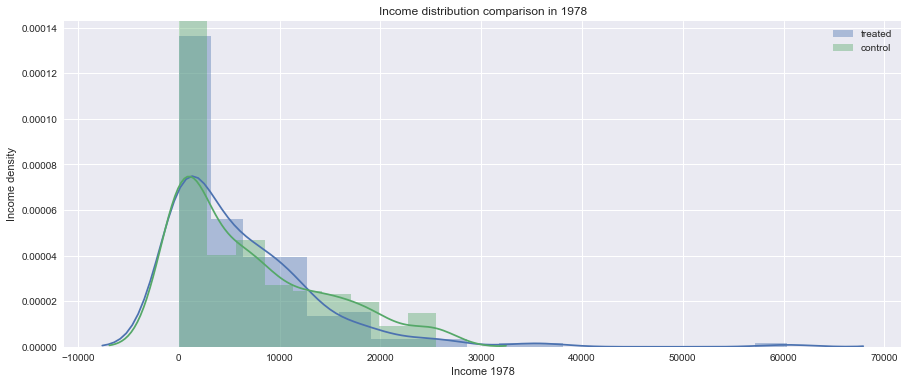

In [50]:
distr_comp(treated,control,'re78','Income distribution comparison in 1978','Income 1978','Income density')

In the plot above we can observe more or less that the two groups share shame distribution over the income. The difference, which we observe though is that in general the untrained people are having much higher income in most cases. They obviously dont have the highest income as there are records of trained people with the maximum income recorded but in the interval between <b>12000 - 27000</b> the control group outperform the treated one. Also the intervals where the number of treated is higher are the ones that correspond to lower income. We have to take into consideration that under the umbrella of naive approach we don't perform a more extensive research on how the distribution behave if we decrease the bin size-(in order to fit the data much more precisely).

<b>Conclusion Naive Analysis</b>

We conclude that in general the control group outperforms the treated one in most of the cases and we get the intuition, that eventually participating in the programme didn't really help the participants in terms of future income increase. The statistics but also the distributions indicate that (without minding standard deviation) in average the control group has higher income. 

The treated group has:
    1. lower mean earnings value
    2. higher first (25%) percentile - low income interval (though)
    3. Some outliers of really high income rates - with maximum income
The control group has:
    1. higher mean earnings value
    2. higher percentile (50%,75%)
    3. higher number of people with income in the interval 12000 - 27000
    4. possible* higher unemployment rate (as higher number of 0 income means unemployment) 

However as we also noticed in the beginning the dataset is not balanced and the control group has much more members than the one of treated. Due to our naive analysis we will leave this detail(important in statistics point of view) aside. 

*We say possible because in our naive analysis we didn't tried greater number of bins in the histogram.

### Task 2. A closer look at the Data

In order to take a closer look on the dataset we thought that we should use more features in order to reach a soid conclusion. So the first thing is to see how much correlation exist between the attributes of the dataset. To do that we will plot a pairwise correlation of each feature. We are interested in specific pairs, so we will comment only on the significant ones.

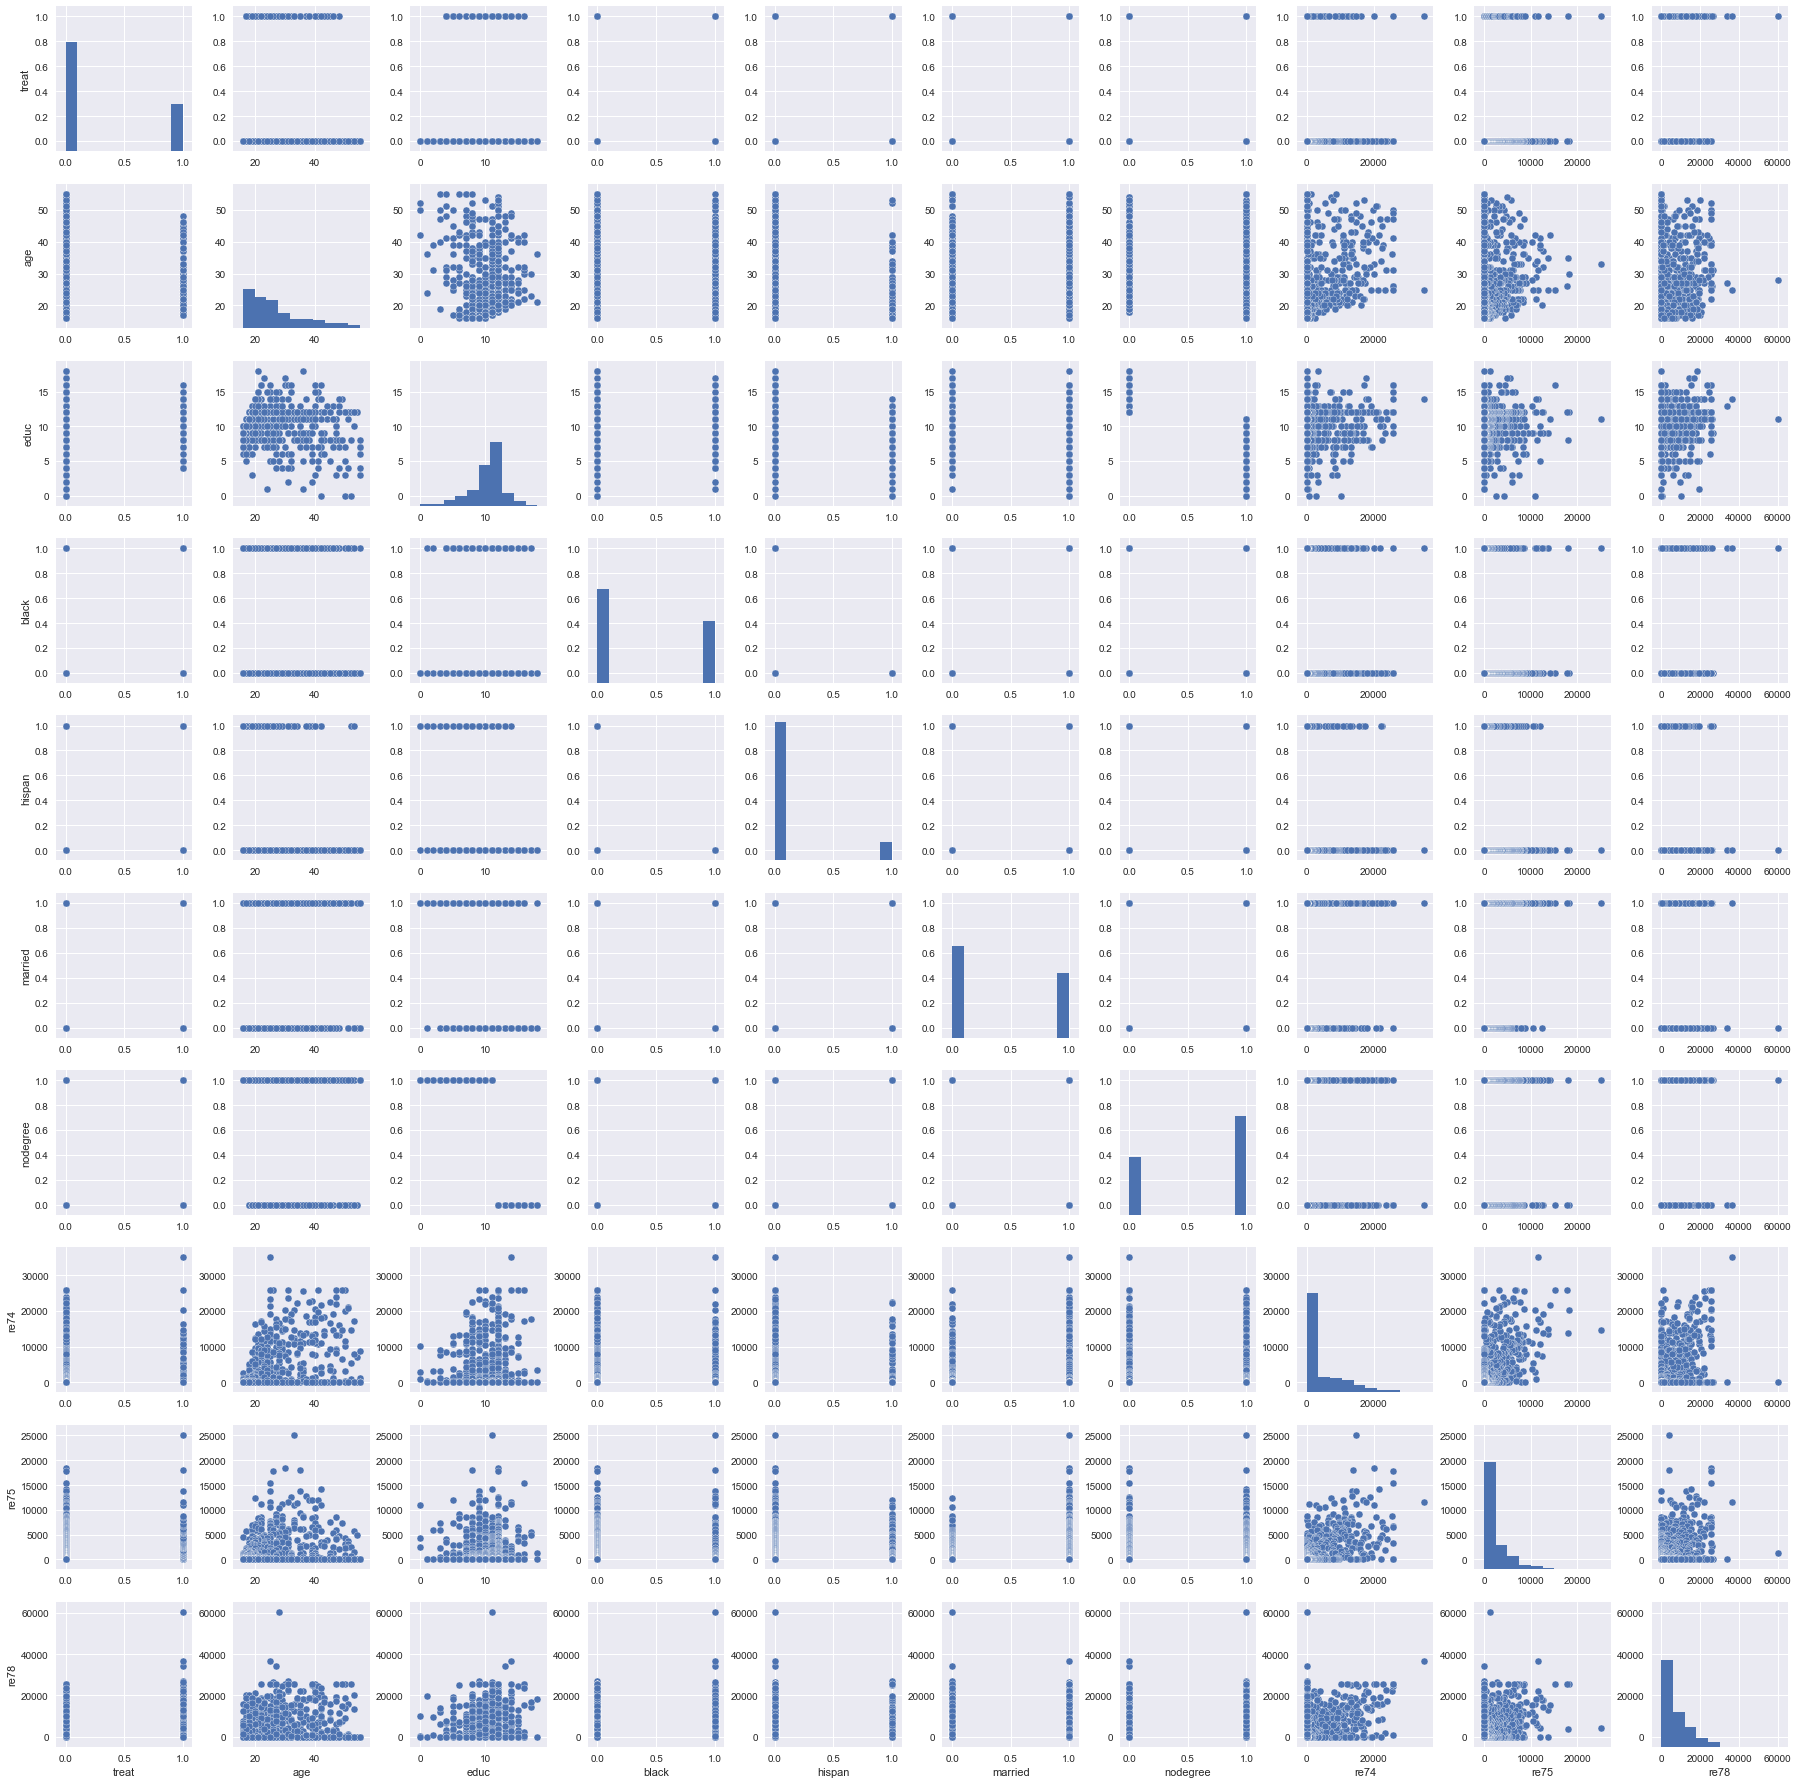

In [51]:
sns.pairplot(lalonde_data)

We have to comment, that we used pairplot for simplicity of code. We would examine only the first column, where we can see the correlation between the two groups and the features. Additionally since some attributes are categorical like married,race...will not examine them now but in the next stages. From the correlation plots we can notice that:

1. The number of records for the treated is higher than the records for the control group
2. The control group includes much larger range of ages whereas the treated one has members with age between 18-50
3. The education level of all the members of the treated group is above 4 years whereas in the control group there are also members that have not education at all.
4. We can also notice some outliers in the data on the plots of incomes during the recorded years.

Now that we have observed some special aspects of our dataset we will analyze them more in depth. We will do that using some basic statistical principles like visualization techniques and other more robust statistical metrics.

### Age 
We will first investigate the age distribution of the two groups. We notice that there is much difference between the tow groups on this attribute. As we noted previously the members of the treated tend to be younger than the ones in the control group. We 've reached this conslusion from the boxplot below. However the median of the two groups is not so different.

/Users/josifosk/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


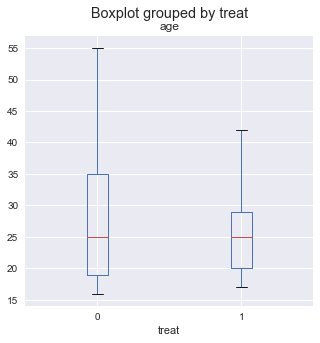

In [52]:
lalonde_data.boxplot(by='treat', column='age', figsize = [5, 5], grid=True)
plt.show()

Its easy to observe from the plot below that the age distribution is quite different between the two groups. In the treated group there are much more members in the ages between 18-28 and in the control group there are much more members in the interval 34-55.

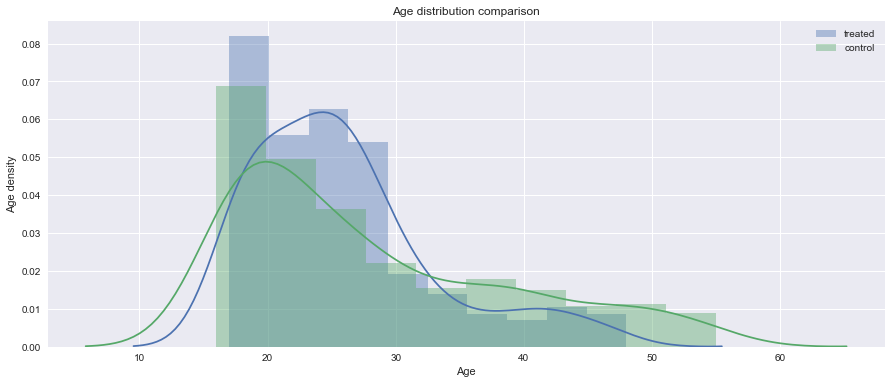

In [53]:
distr_comp(treated,control,'age','Age distribution comparison','Age','Age density')

Below we sketch a Q-Q plot to see if the distributions are similar. If the two distributions being compared are similar, the points in the Q–Q plot will approximately lie on the line y = x. If the distributions are linearly related, the points in the Q–Q plot will approximately lie on a line, but not necessarily on the line y = x. If the points follow a strongly nonlinear pattern then the distributions are not similar.

In [54]:
def qq(df,col):
    fig_qq, ax_qq = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

    stats.probplot(df[df.treat == 0][col], dist="norm", plot=ax_qq[0])
    stats.probplot(df[df.treat == 1][col], dist="norm", plot=ax_qq[1])
    ax_qq[0].set_title('Control Group')
    ax_qq[1].set_title('Treated Group')
    plt.show()

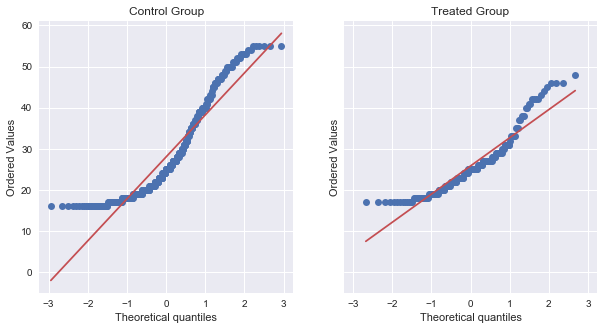

In [55]:
qq(lalonde_data,'age')

### Education
We will implement the above and same logic for the attribute of education.


/Users/josifosk/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


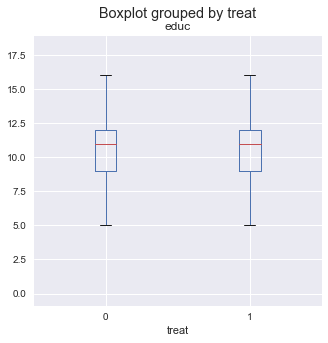

In [56]:
lalonde_data.boxplot(by='treat', column='educ', figsize = [5, 5], grid=True)
plt.show()

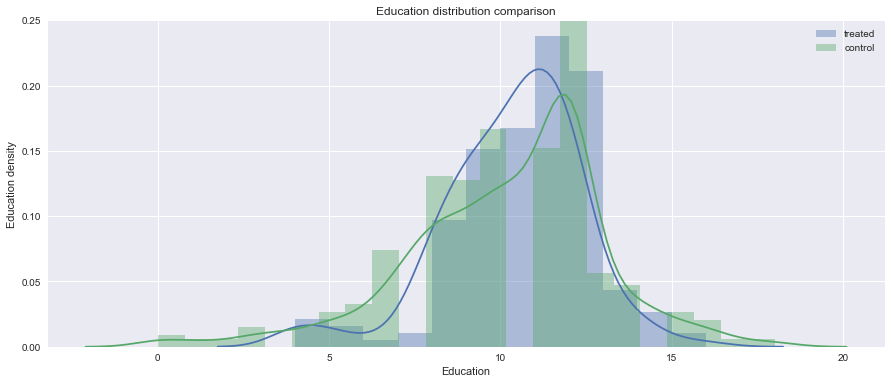

In [57]:
distr_comp(treated,control,'educ','Education distribution comparison','Education','Education density')

We can observe here easily that the treated group has no members that have never been educated whereas the control group has. Every other interval is difficult to infer as there are outliers.

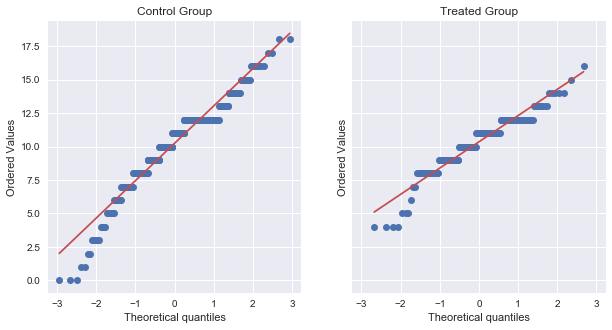

In [58]:
qq(lalonde_data,'educ')

### Income of previous year 1974


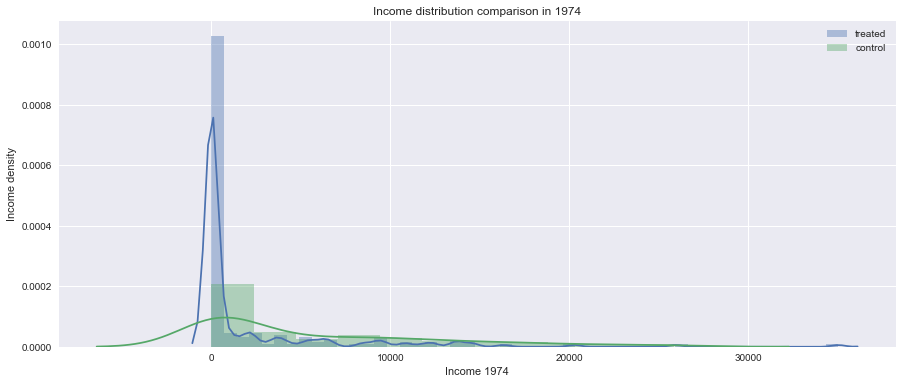

In [59]:
distr_comp(treated,control,'re74','Income distribution comparison in 1974','Income 1974','Income density')

As we can observe from this attribute the number of treated members that were unemployed before the training programme is quite high. So this might gives us an intuition of how much the programm helped people to find a job independently of the income that they got eventually. This is also obvious from the boxplot bbelow where we can notice that although there are employed members in the control group in the treated one there is quite high unemployment.

/Users/josifosk/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


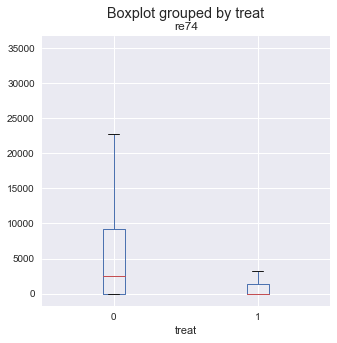

In [60]:
lalonde_data.boxplot(by='treat', column='re74', figsize = [5, 5], grid=True)
plt.show()

### Categorical Data

In [61]:
def cat_plot(df,col):
    group = df.groupby(['treat', col])[col].count()
    group = group.unstack()
    group = group.div(group.sum(axis=1), axis=0)
    pl = group.plot(kind='bar', figsize=[7,5], rot=0)
    pl.set_title(col)
    pl.set_ylabel('participants')
    pl.set_xlabel('group')
    plt.show()

### Marriage


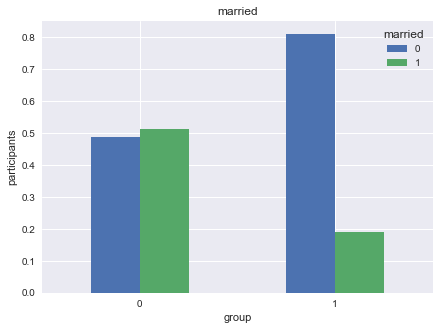

In [62]:
cat_plot(lalonde_data,'married')

As far as we can see the percentage of the unmarried people between the treated group is much higher than the married ones whereas in the control group the two categories are balanced. This might be an indication of what type of people they tried to include in their programme. 

### Educational degree indicator attribute

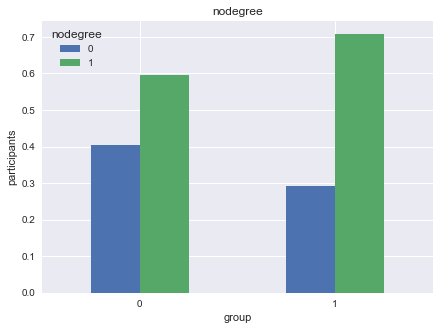

In [63]:
cat_plot(lalonde_data,'nodegree')

We observe that in both groups the number of people that do not have a degree is higher than the ones that have one.However the difference in the treated group is much higher. 

### Race
In order to infer the white race also we will create a logical operation between the other two races and the difference will be the white race.

In [64]:
lalonde_data['white'] = (~(lalonde_data['black'].astype(bool) | lalonde_data['hispan'].astype(bool))).astype(bool)

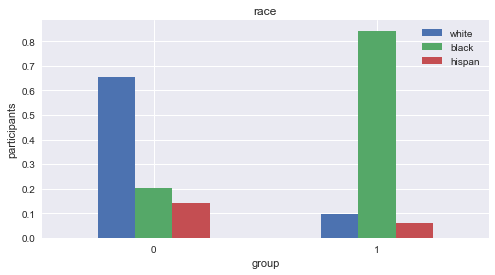

In [65]:
lalonde_data_group = lalonde_data.groupby(lalonde_data.treat)['white', 'black', 'hispan'].sum()
lalonde_data_group = lalonde_data_group.div(lalonde_data_group.sum(axis=1), axis=0)
pl = lalonde_data_group.plot(kind='bar', figsize=[8,4], rot=0)
pl.set_title('race')
pl.set_ylabel('participants')
pl.set_xlabel('group')
plt.show()

So about the racial features of the two groups is very obvious that the white outnumber the other races in the control group and on the other hand in the treated group the proportion of black is almost the only one. The black race have a percentage above 80% of the whole in the treated dataset.

### Task 3. A propensity score model

As we have seen during the lectures, having balanced covariate distributions in both the treatment and the control dataset is an essential thing for a meaningful observational study. The prior analysis showed that the original datasets lacks that property, hence we will use propensity scores and matching to constract a new, valuable dataset.

Concerning the propencity scores estimation, as mention in the <a href='http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf'>book</a> by Rosenbaum, logistic regression is a tool that can efficiently deal with that task. Evenmore, it has been proven that the tendency for the estimators to slightly overfit and produce 'too much covariate balance' can even improve performance, since thats precisely what we want.

Having this in mind for estimating the propencity scores we use a logistic regression model, with a parameter C set to high value, since there is no need for too much regularization. For the model training, all of the attributes, except for the *re78* are used, since all of others are observed prior to treatment.

Taking into consideration the fact that the data has been collected in a period when race and ethnicity played a significant role in employement criteria, and hypothesising (supported from the prior analysis) that race has an influence in the outcome of our dataset as well, in order to complete the picture we add another indicator attribute *other_race* which is equal to 1, only when both *hispan* and *black* are 0s. This attribute is added to the features used in training the model as well.

In [71]:
# Add the other_race attribute to the dataset
df = pd.read_csv("lalonde.csv")
df['other_race'] = abs((df['black'] | df['hispan'])-1)
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,other_race
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0


In [72]:
from sklearn import linear_model
cls = linear_model.LogisticRegression(C=1e2)

# Separate the used features
features = ['age', 'educ', 'black', 'hispan', 'other_race', 'married', 'nodegree', 're74', 're75'] 
features_df = df[features]

X = features_df.values.astype(float)
Y = df.treat.values

# Fit the model
cls.fit(X, Y)

# Inspecting the output
print("Possible classes: \n", cls.classes_)
print("Regression predictions for the first 3 instances: \n", cls.predict_proba(X[:3]))

# Extracting the estimated 
propensity_score = cls.predict_proba(X)[:, 1]

print("Propensity scores for the first 3 instances: \n", propensity_score[:3])

Possible classes: 
 [0 1]
Regression predictions for the first 3 instances: 
 [[ 0.48563737  0.51436263]
 [ 0.70916547  0.29083453]
 [ 0.34763627  0.65236373]]
Propensity scores for the first 3 instances: 
 [ 0.51436263  0.29083453  0.65236373]


We add the estimated propensity score to the dataframe

In [73]:
df['Propensity_score'] = propensity_score

## Task 4. Balancing the dataset via matching

Now we need to generate a meaningful matching between instances in the control and treatment group based on the propensity scores assigned to every instance.

In the book by Rosenbaum it is mentioned that there is no 'silver bullet' that works best for all matching problems, but instead there a few techniques like :
* introducing a caliper imposed through a penalty function that keeps the propensity score in some range and applies penalties when outside the range, or
* explicitly matching on a attributes that are hard to balance

which are applied in iterations until we are happy with the matching.

For this task, we implement the simplest, full matching and analyse the results.

In order to perform matching between pairs a distance/similarity function is needed. Since the library used for the matching (networkx) has a function that maximizes the sum of weights between pairs, it is natural to use a function that measures similarity.

Wanting to minimize the difference of propensity scores between pairs, we define the similarity function between two instances $x$ and $y$ like:

$$ similarity(x,y) = 1 - | propensity\_score(x) - propensity\_score(y) |$$

This function captures the difference in scores like a distance, but since the distance defined like that would always be between 0 and 1, subtracting it from 1 would be a meaningful measure to use for similarity.

In [74]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [75]:
def match_instances_on_propensity_score(df, treshold=None):
    '''Generates a matching on propensity scores given a dataframe
    of instances assigned with their corresponding scores'''
    
    # Separate the treatment and control groups
    treatment_df = df[df['treat'] == 1]
    control_df = df[df['treat'] == 0]
    
    # This is a functionality used in Task 5, which calculates a treshold
    # value (if the indicator is set in the function call) used for removing
    # edges between instances that have larger distance than 0.2 * std(propensity_score),
    # which is a usually a good choice in practice (supported by experiments
    # as discussed in the previously cited book)
    if treshold != None:
        std = np.std(df['Propensity_score'])
        treshold_value = std * 0.2
        treshold_value = 1 - std * 0.2
    
    # Create an empty undirected graph
    G = nx.Graph()
    
    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            
            # Calculate the similarity 
            similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])
            
            # If the treshold option is not used, add an edge between the two
            # instances weighted by the similarity between them, otherwise
            # add the edge only if similarity is higher then calculated value
            if treshold == None:
                G.add_weighted_edges_from(\
                    [(control_id, treatment_id, similarity)])
            else:
                if similarity > treshold_value:
                    G.add_weighted_edges_from(\
                        [(control_id, treatment_id, similarity)])
    
    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    return matching

The function above is used to generate a matching between pairs in control and treatment, from which we construct a new dataset. In the remaining part of the task, we analyse the distribution of covariance between the two groups in the newly constructed dataset. 

In [76]:
matching = match_instances_on_propensity_score(df)
balanced_df_1 = df.iloc[list(matching.keys())]

The analysis that we will be doing is the same for all of the numeric attribues, and same for all of the indicator attributes. Hence we define some functions that we will use repeatedly in our analysis.

In [123]:
sns.set_style('whitegrid')
def draw_boxplot(df, column_name, ax=None, size=(5,5), x_label=None, y_label=None):
    '''Draws two boxplots side by side to visualize the distribution
    of a given column for the control and treatment'''
    if ax == None:
        fig, ax = plt.subplots(figsize=size)

    # Draw boxplot
    ax = sns.boxplot(x='treat', y=column_name, data=df, fliersize = 0, ax=ax)
    plt.setp(ax.artists, alpha=.35)

    # Draw swarmplot
    plot = sns.swarmplot(x='treat', y=column_name, data=df, size=2.2, linewidth=0, ax=ax)

    # Provide Lables
    if(x_label != None):
        ax.set_xlabel(x_label, fontsize=20)
    if(y_label != None):
        ax.set_ylabel(y_label, fontsize=20)
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)

def draw_distplot(df, column_name, ax=None, size=(5,5), x_label=None, y_label=None):
    '''Draws the histograms and density for the distributions of an attribute
    for in the control and treatment group'''
    if ax == None:
        fig, ax = plt.subplots(figsize=size)
    
    # Draw both distplots
    plot1 = sns.distplot(df.loc[df.treat==0][column_name], label='Control', ax=ax)
    plot2 = sns.distplot(df.loc[df.treat==1][column_name], label='Treatment', ax=ax)
    
    # Provide labels
    if(x_label != None):
        ax.set_xlabel(x_label, fontsize=20)
    if(y_label != None):
        ax.set_ylabel(y_label, fontsize=20)
    ax.legend(prop={'size': 20})
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)
    
def draw_q_q_plot(df, column_name, ax=None, size=(5,5), x_label=None, y_label=None):
    '''Draws q-q plot for the distribution of the attribute column in 
    the control group, compared to the distribution of the attribute in 
    the treatment group'''
    if ax == None:
        fig, ax = plt.subplots(figsize=size)
    # Get both samples
    sample1 = df.loc[df.treat==1][column_name].values
    sample2 = df.loc[df.treat==0][column_name].values

    # Get quantiles
    sample1.sort()
    quantile_levels1 = np.arange(len(sample1),dtype=float)/len(sample1)
    sample2.sort()
    quantile_levels2 = np.arange(len(sample2),dtype=float)/len(sample2)

    # Interplolate quantiles of large sample, according to the sample that has less quantiles
    if len(sample1) >= len(sample2):
        quantile_levels = quantile_levels2

        quantiles2 = sample2
        quantiles1 = np.interp(quantile_levels, quantile_levels1, sample1)
    else:
        quantile_levels = quantile_levels1

        quantiles1 = sample1
        quantiles2 = np.interp(quantile_levels, quantile_levels2, sample2)

    # Draw the scatter plot
    ax.scatter(quantiles1,quantiles2)
    
    # Draw the optimal line
    maxval = max(sample1[-1],sample2[-1])
    minval = min(sample1[0],sample2[0])
    ax.plot([minval,maxval],[minval,maxval],'k--', alpha=.5)

    # Provide labels
    if(x_label != None):
        ax.set_xlabel(x_label, fontsize=20)
    if(y_label != None):
        ax.set_ylabel(y_label, fontsize=20)
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)

def draw_barplot(df, column_name, ax=None, size=(5,5), x_label=None, y_label=None):
    '''Draws barplot with 95% confidence interval for a attribute column
    in the control and treatment group'''
    if ax == None:
        fig, ax = plt.subplots(figsize=size)
    
    # Draw barplot
    sns.barplot(x='treat', y=column_name, ci=95, data=df, ax=ax)

    # Provide labels
    if(x_label != None):
        ax.set_xlabel(x_label, fontsize=20)
    if(y_label != None):
        ax.set_ylabel(y_label, fontsize=20)
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)
    
def get_describtive_stats(df, column_name):
    '''Generates the descriptive statistics for a given attribute in
    the control and treatment group, together with the differences between them'''
    control = df.loc[df.treat==0][column_name].describe()
    treatment = df.loc[df.treat==1][column_name].describe()
    
    descriptive_stats = pd.DataFrame()
    
    descriptive_stats['Control'] = control
    descriptive_stats['Treatment'] = treatment
    descriptive_stats['Difference'] = \
        np.abs(descriptive_stats['Control'] - descriptive_stats['Treatment'])
        
    return descriptive_stats

def describe_numerical_attribute(df, column_name, column_descriptive_name):
    '''Wrapper function for describing a numerical attribute'''
    fig = plt.figure(figsize=(24,24))
    print("%s attribute analysis" % column_descriptive_name)

    ax1 = fig.add_subplot(221)
    draw_distplot(df, column_name, ax=ax1, x_label='Treatment', y_label=column_descriptive_name)

    ax2 = fig.add_subplot(222)
    draw_boxplot(df, column_name, ax=ax2, x_label='Treatment', y_label=column_descriptive_name)

    ax3 = fig.add_subplot(223)
    draw_q_q_plot(df, column_name, ax=ax3, x_label = 'Quantiles for treatment', y_label = 'Quantiles for control')

    ax4 = fig.add_subplot(224)
    draw_barplot(df, column_name, ax=ax4, x_label = 'Treatment', y_label=column_descriptive_name)
    
    plt.show()
    return get_describtive_stats(df, column_name)

def describe_indicator_attribute(df, variables):
    '''Function for providing a normalized countplot for indicator attributes'''
    # Filter the variables of interest
    temp_df = df[variables]
    
    # Count the total number of elements in each group for normalization
    total_num_of_elements = temp_df.groupby('treat').count()
    
    # Count the number of elements of interest in each group
    temp_df = temp_df.groupby('treat').sum()
    temp_df = temp_df / total_num_of_elements
    
    # Transpose in order to have the attributes by group together on the plot
    temp_df = temp_df.T.reset_index()
    
    # Change column names for interpretability
    temp_df.columns = ['Attribute', 'Control', 'Treatment']
    plot = temp_df.plot.bar(x='Attribute', y=['Control', 'Treatment'])
    
    # Provide label names
    plot.set_ylabel("Portion of dataset", fontsize=15)
    plot.figure.set_size_inches(10,5)
    plot.axes.set_xticklabels(temp_df['Attribute'], rotation=45)
    plot.axes.tick_params(labelsize=12)
    plot.xaxis.label.set_fontsize(15)

### Age attribute

Age attribute analysis


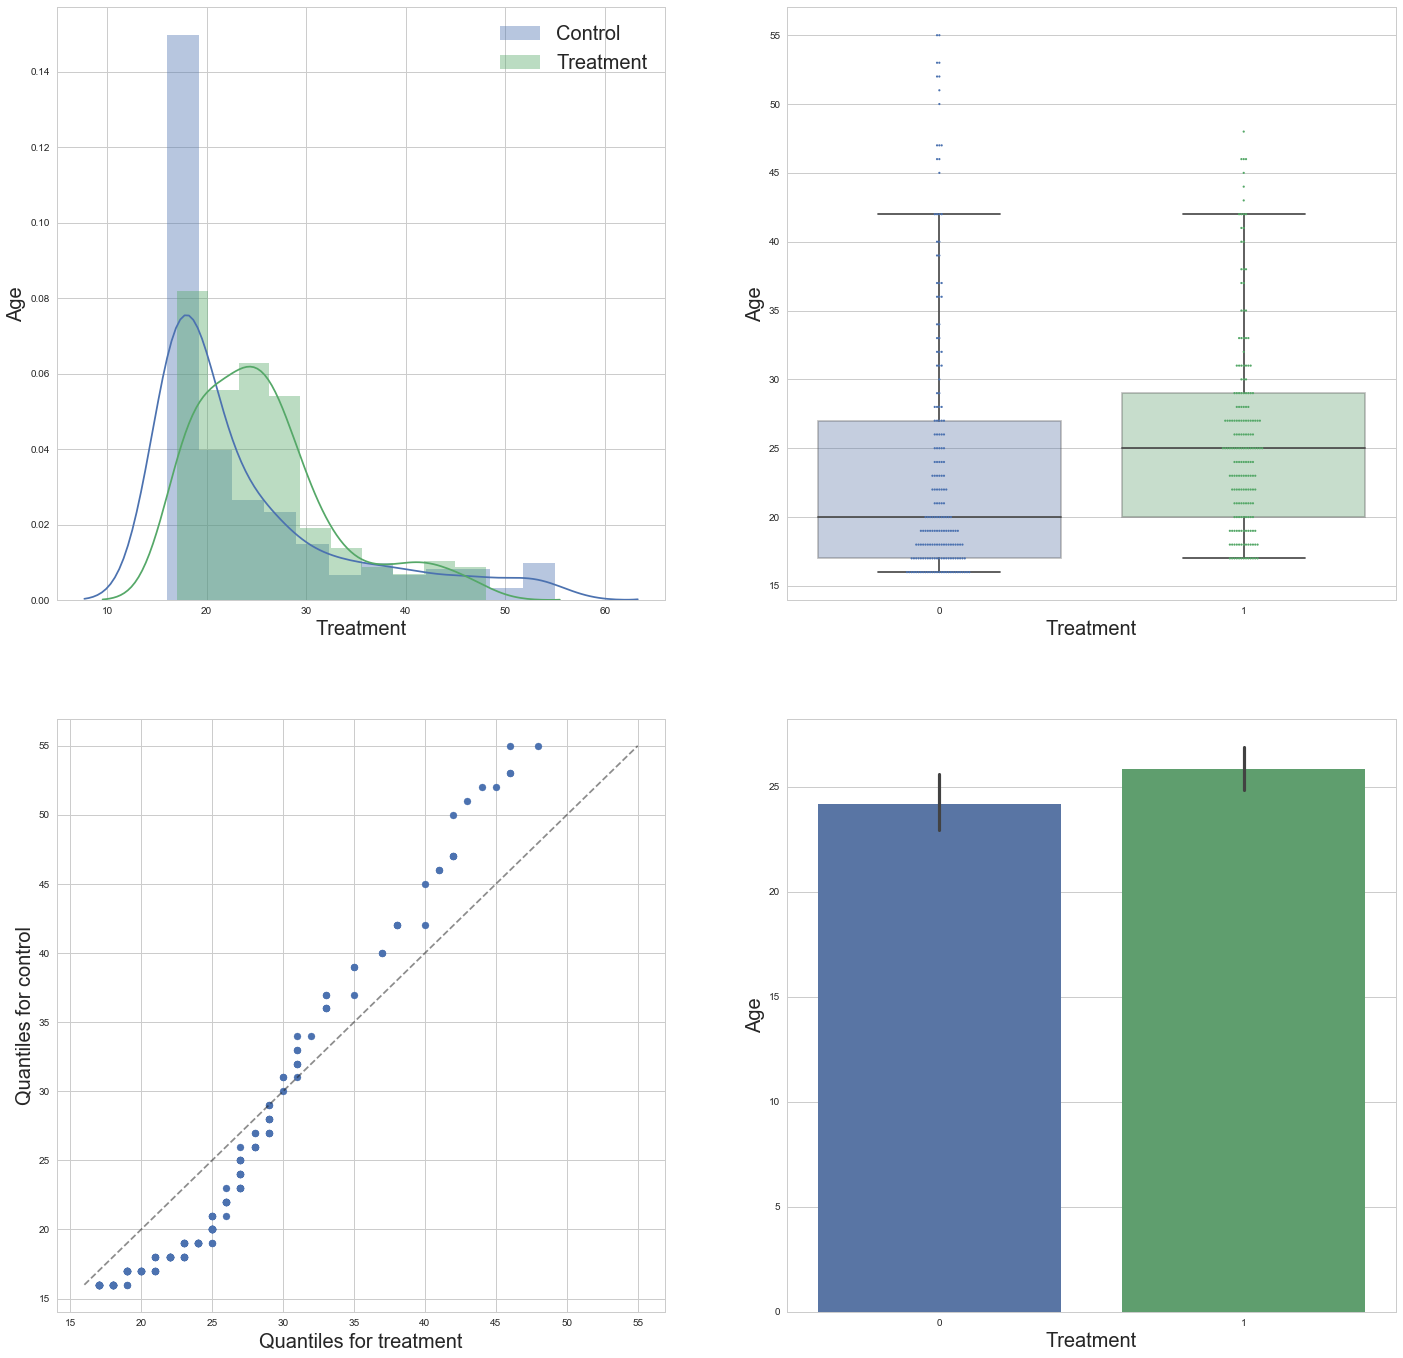

,Control,Treatment,Difference
count,185.000000,185.000000,0.000000
mean,24.167568,25.816216,1.648649
std,9.919734,7.155019,2.764714
min,16.000000,17.000000,1.000000
25%,17.000000,20.000000,3.000000
50%,20.000000,25.000000,5.000000
75%,27.000000,29.000000,2.000000
max,55.000000,48.000000,7.000000


In [77]:
describe_numerical_attribute(balanced_df_1, 'age', 'Age')

The barplot and the mean in the descriptive statiscs show that the distribution of the age attribute is centered closely in the two groups, but from the histogram, boxplots, q-q plot, as well as quartiles we see that the tails differ significantly i.e the control group tents to have more numerous younger population than the treatment, as well as more "outliers" (small number of individuals that differ significantly from the mean).

### Education attribute

Education attribute analysis


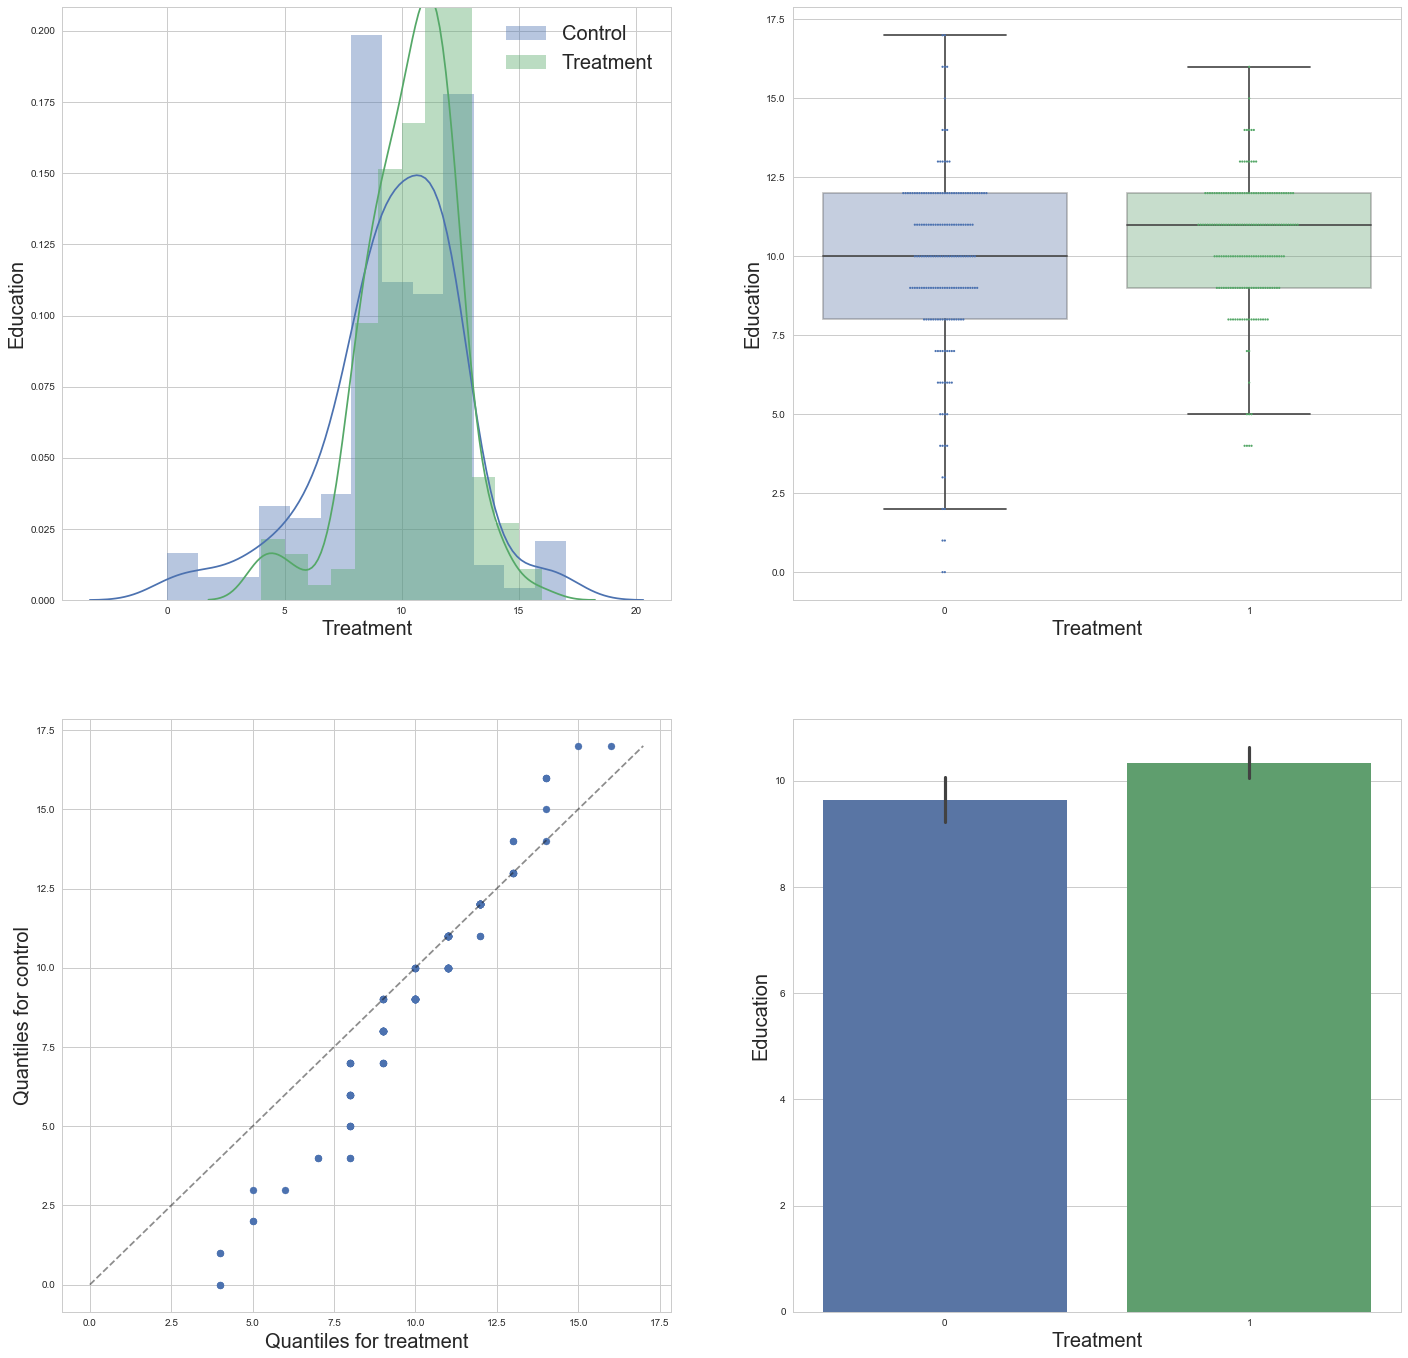

,Control,Treatment,Difference
count,185.000000,185.000000,0.000000
mean,9.643243,10.345946,0.702703
std,2.958457,2.010650,0.947807
min,0.000000,4.000000,4.000000
25%,8.000000,9.000000,1.000000
50%,10.000000,11.000000,1.000000
75%,12.000000,12.000000,0.000000
max,17.000000,16.000000,1.000000


In [78]:
describe_numerical_attribute(balanced_df_1, 'educ', 'Education')

For the education attribute, from the figures above we can see that the distributions between the two groups match closely for the last 3 quartiles and the means are comparable. There is a slight difference in the first quartile, which states that a small portion of the control group has slighly less years of education that the first quartile in the treatment group, hence we can consider this attribute as well balanced.

### Race attributes

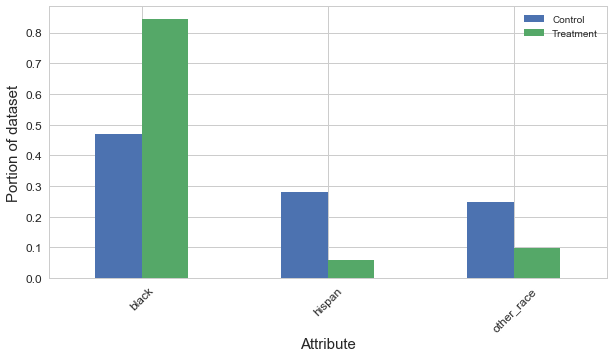

In [79]:
describe_indicator_attribute(balanced_df_1, ['treat', 'black', 'hispan', 'other_race'])

From the plot above it can be observed that there is a terrible disbalance in the distribution of individuals with respect to race in the control and treatment datasets. Which can impact the conclusion from the study, as discussed before, hence it must be dealt with.

### Marital status attribute

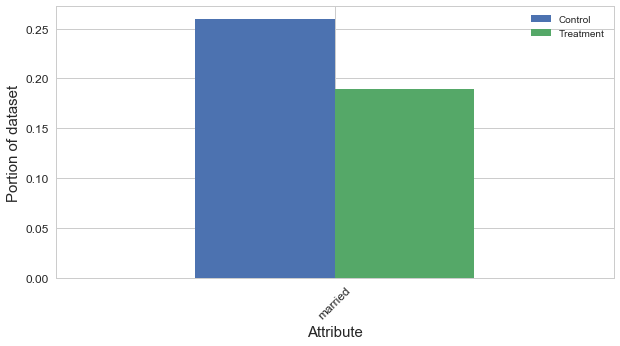

In [80]:
describe_indicator_attribute(balanced_df_1, ['treat', 'married'])

The portion of married individuals in both groups seems to be slightly imbalanced, but comparable.

### Educational degree indicator attribute

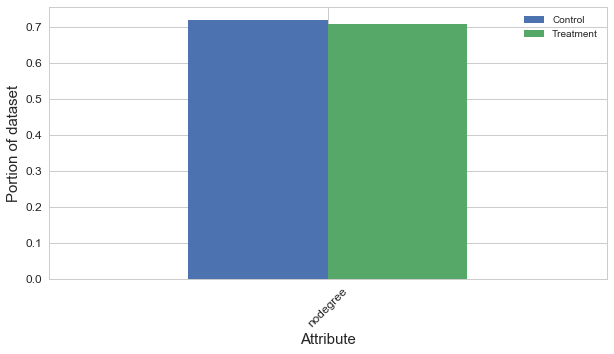

In [81]:
describe_indicator_attribute(balanced_df_1, ['treat', 'nodegree'])

The portion of individuals with no degree seems perfectly balanced in both groups.

### Real earnings in 1974

Real earnings in 1974 attribute analysis


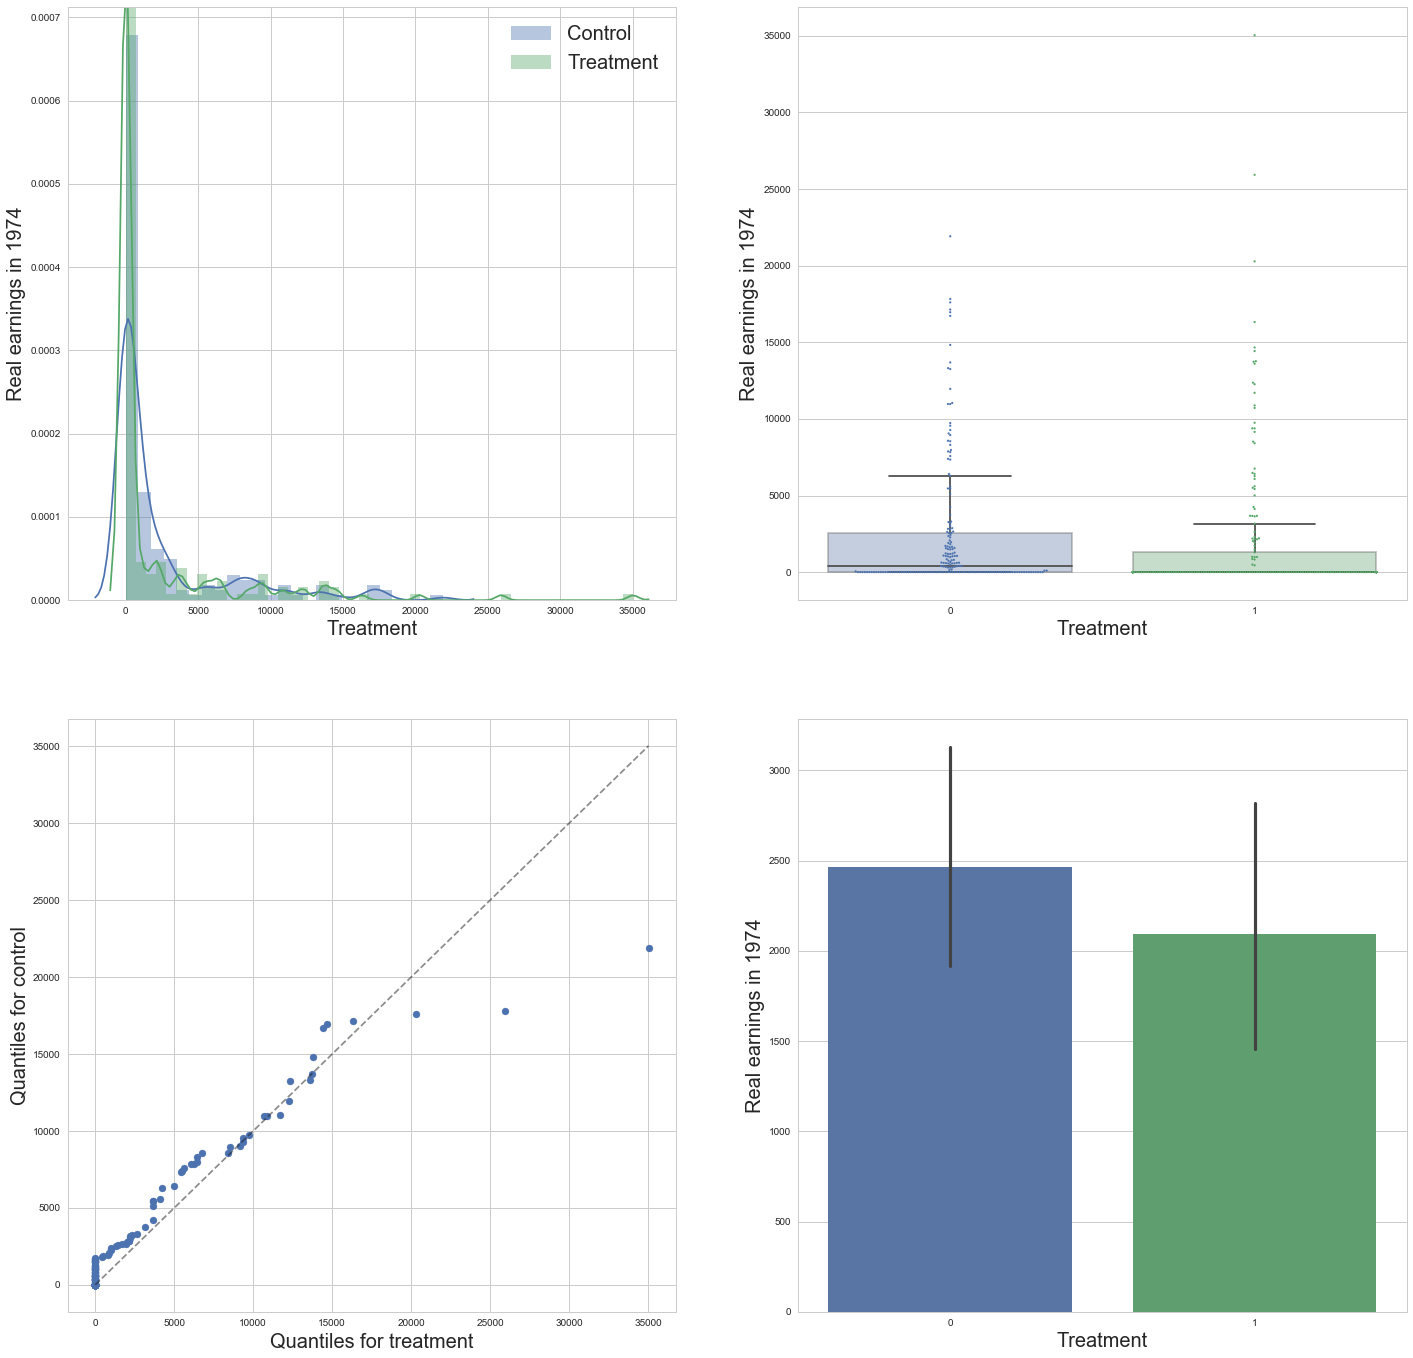

,Control,Treatment,Difference
count,185.000000,185.000000,0.000000
mean,2463.126673,2095.573689,367.552985
std,4369.135286,4886.620353,517.485067
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,384.016300,0.000000,384.016300
75%,2539.210000,1291.468000,1247.742000
max,21918.320000,35040.070000,13121.750000


In [82]:
describe_numerical_attribute(balanced_df_1, 're74', 'Real earnings in 1974')

The histogram, q-q plot and descriptive statistics clearly show that the distributions are quite similar. There are just a few "outliers" with high earning in the control group, which are seen in the first three plots, and account for the small difference in means in the forth one.


### Real earnings in 1975

Real earnings in 1975 attribute analysis


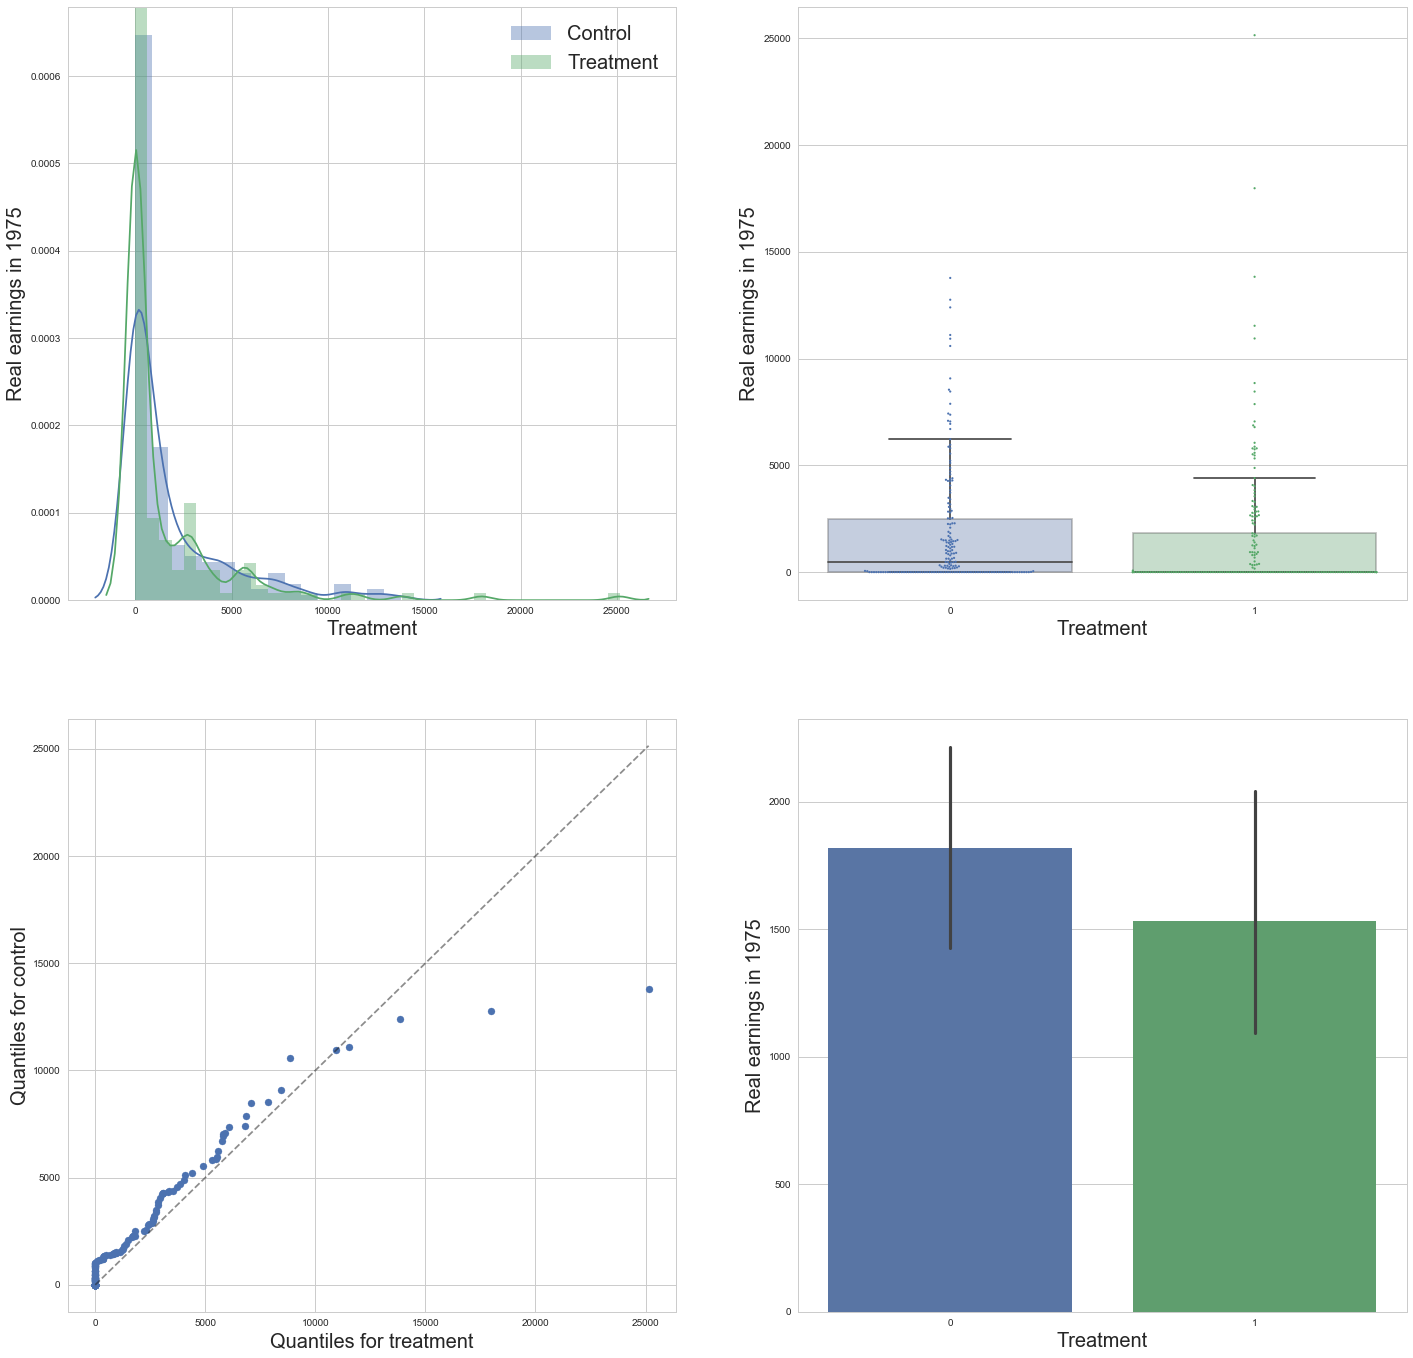

,Control,Treatment,Difference
count,185.000000,185.000000,0.000000
mean,1820.448360,1532.055314,288.393046
std,2835.619205,3219.250870,383.631665
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,469.064500,0.000000,469.064500
75%,2506.452000,1817.284000,689.168000
max,13776.530000,25142.240000,11365.710000


In [83]:
describe_numerical_attribute(balanced_df_1, 're75', 'Real earnings in 1975')

All of thes figure show that the distribution is similar in both groups.

From the above analysis we notice that the race imbalance is the most severe one, and in the next task we will try to resolve it.

## Task 5. Balancing the groups further

As discussed before there are several ways on how we can approach the problem. For the purpose of solving this task we tried two. We tried filtering the edges, using a treshold value equal to $0.2 * std(propensity\_score)$ and $0.1 * std(propensity\_score)$, which provided significant balancing between the races, but wasn't enough, hence we tried matching only people who are from the same race and this resulted with the best performance. A solution where we used the treshold technique with direct matching was also tried out, but provided poorer performance especialy with the continuous variables with larger range such as *educ*, *re74* and *re75*. In interest of presentability and brevity we only showcase the best technique.

The size of the sample after the matching is 232 individuals, which is a descrease from the initial matching of 330 individuals, but again represents a descent sized datasets for generating conclusions.

In [84]:
def match_instances_on_propensity_score_and_race(df, treshold=None):
    '''Generates a matching on propensity scores only between individuals from the same race, given a dataframe
    of instances assigned with their corresponding scores'''
    treatment_df = df[df['treat'] == 1]
    control_df = df[df['treat'] == 0]
    
    if treshold != None:
        std = np.std(df['Propensity_score'])
        treshold_value = std * 0.2
        treshold_value = 1 - std * 0.2
    
    G = nx.Graph()
    
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            # Adds an edge only if the individuals have the same race
            if (control_row['black'] == treatment_row['black'])\
                and (control_row['hispan'] == treatment_row['hispan']) and (control_row['other_race'] == treatment_row['other_race']):
                similarity = get_similarity(control_row['Propensity_score'],
                                            treatment_row['Propensity_score'])
                if treshold == None:
                    G.add_weighted_edges_from(\
                        [(control_id, treatment_id, similarity)])
                else:
                    if similarity > treshold_value:
                        G.add_weighted_edges_from(\
                            [(control_id, treatment_id, similarity)])
    
    matching = nx.max_weight_matching(G)
    return matching

In [86]:
matching_all = match_instances_on_propensity_score_and_race(df)
balanced_df_all = df.iloc[list(matching_all.keys())]

### Age attribute

Age attribute analysis


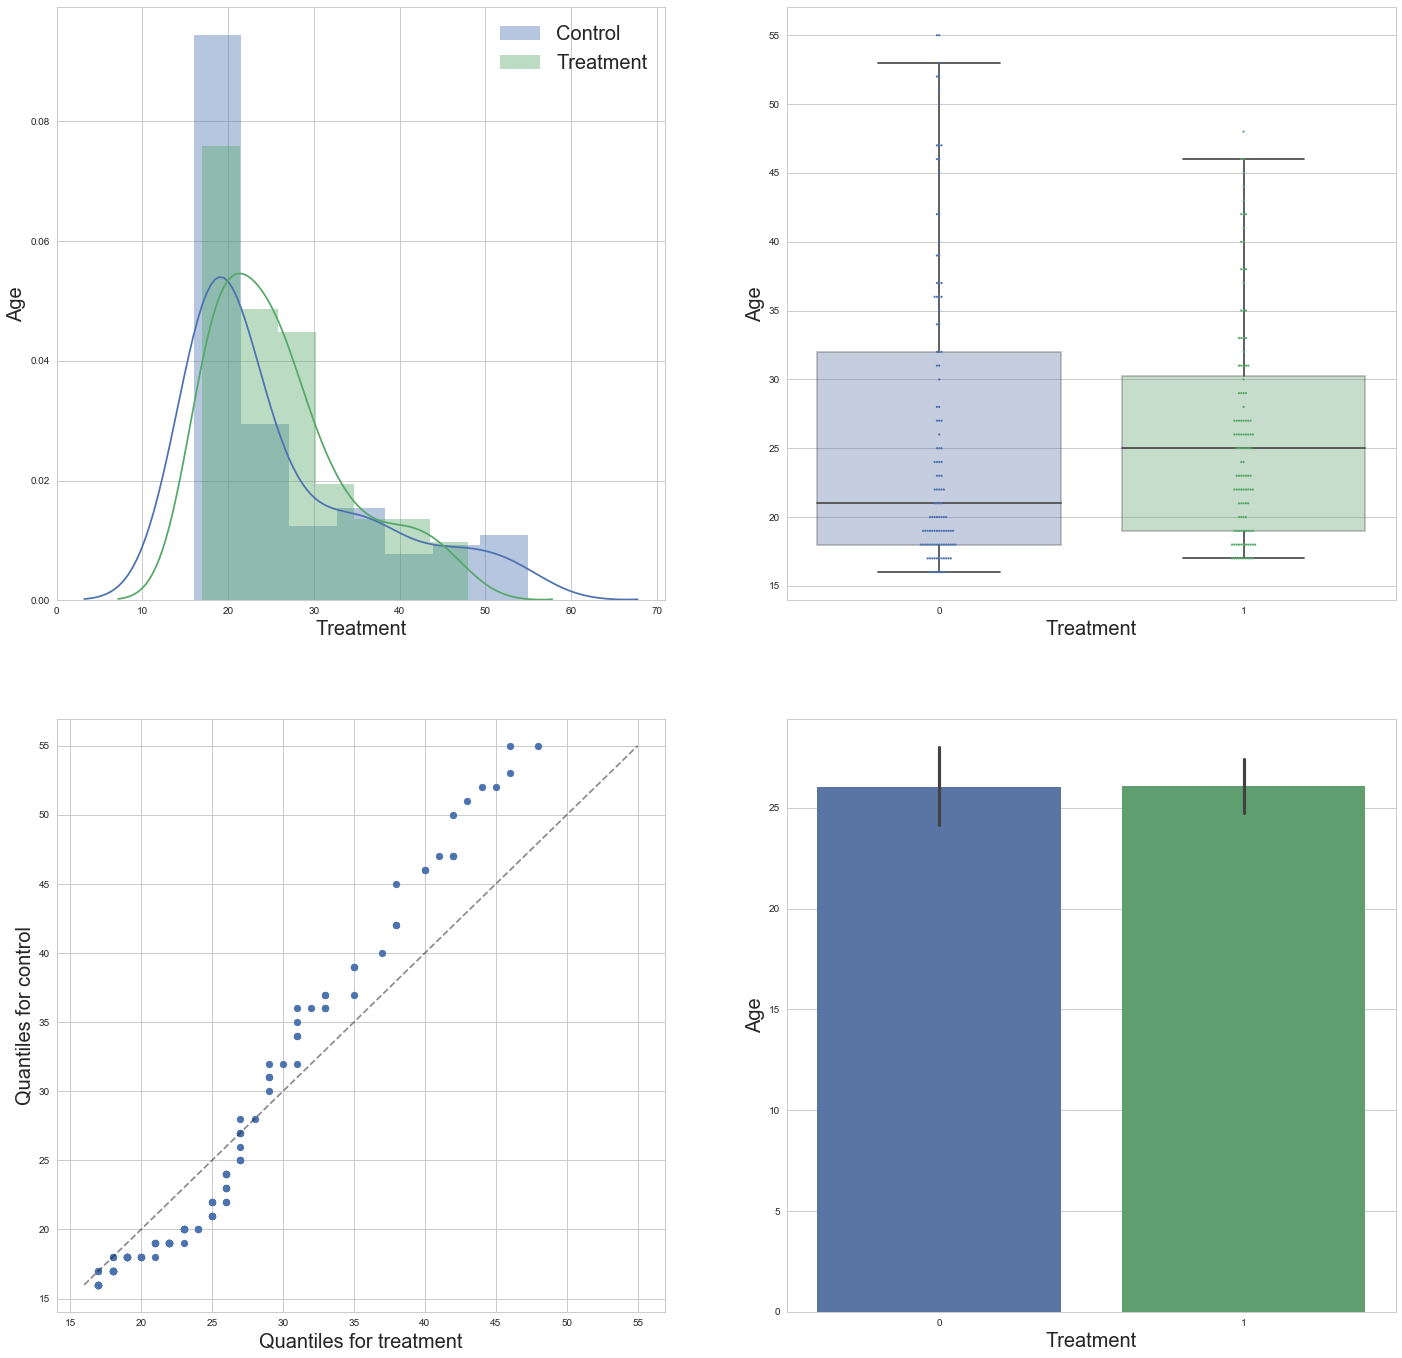

,Control,Treatment,Difference
count,116.000000,116.000000,0.000000
mean,26.034483,26.068966,0.034483
std,10.861124,7.970297,2.890827
min,16.000000,17.000000,1.000000
25%,18.000000,19.000000,1.000000
50%,21.000000,25.000000,4.000000
75%,32.000000,30.250000,1.750000
max,55.000000,48.000000,7.000000


In [87]:
describe_numerical_attribute(balanced_df_all, 'age', 'Age')

The large standard deviation present in the previous matching is smaller, also the first half of the quantiles are closer to each other. Evenmore, the difference between the means of the distributions in both groups is almost apsent. Hence the distributions look better matched than before.

### Education attribute

Education attribute analysis


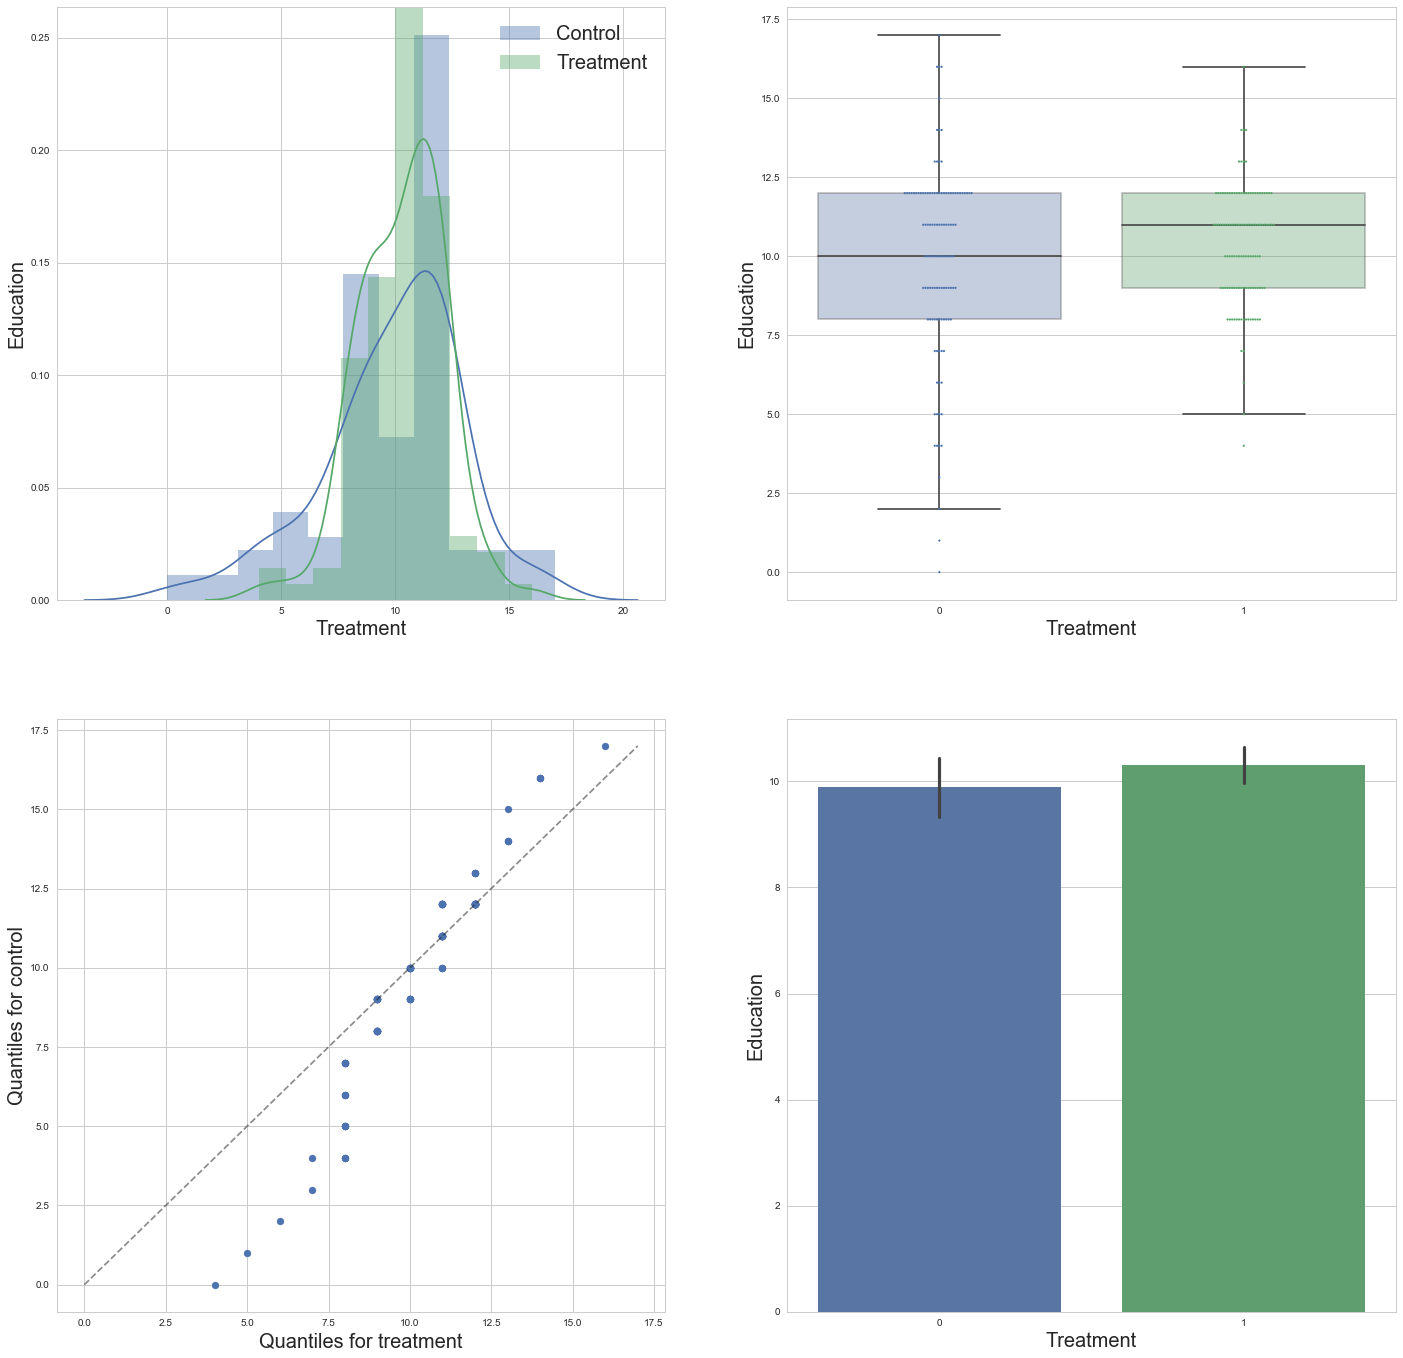

,Control,Treatment,Difference
count,116.000000,116.000000,0.000000
mean,9.887931,10.310345,0.422414
std,3.078033,1.890083,1.187950
min,0.000000,4.000000,4.000000
25%,8.000000,9.000000,1.000000
50%,10.000000,11.000000,1.000000
75%,12.000000,12.000000,0.000000
max,17.000000,16.000000,1.000000


In [88]:
describe_numerical_attribute(balanced_df_all, 'educ', 'Education')

The distribution for this hasn't change from before, from the discussion in the previous tasks we conclude that it is again well balanced. 

### Race attributes

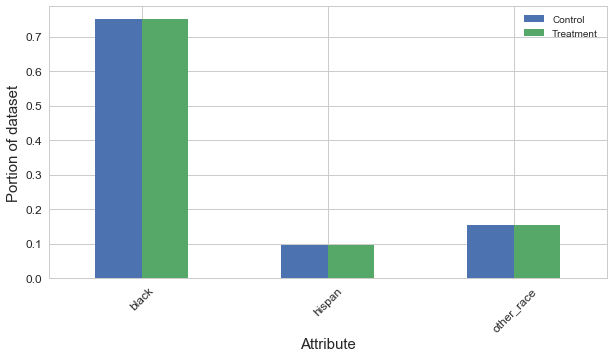

In [89]:
describe_indicator_attribute(balanced_df_all, ['treat', 'black', 'hispan', 'other_race'])

As expected, the change in the approach perfectly balanced the individuals with respect to their race.

### Marital status attribute

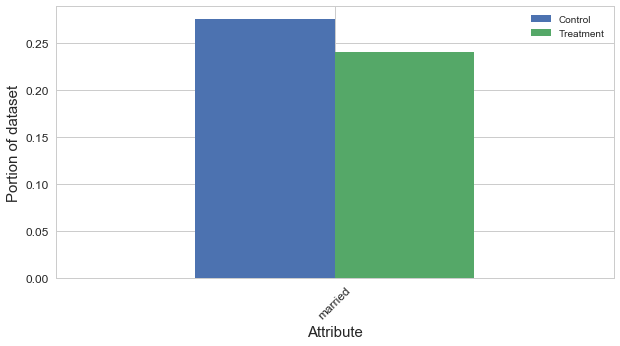

In [119]:
describe_indicator_attribute(balanced_df_all, ['treat', 'married'])

The balance in distribution of married people has also improved with the later matching.

### Educational degree indicator attribute

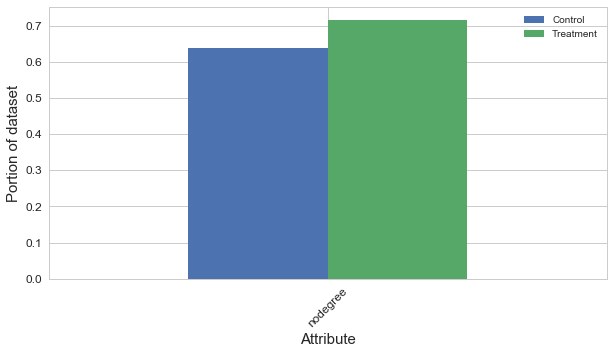

In [91]:
describe_indicator_attribute(balanced_df_all, ['treat', 'nodegree'])

The portion of individuals with no degree, seems to be slightly less balanced compared to the previous matching, but considering the size of the portions it is again well balanced.

### Real earnings in 1974

Real earnings in 1974 attribute analysis


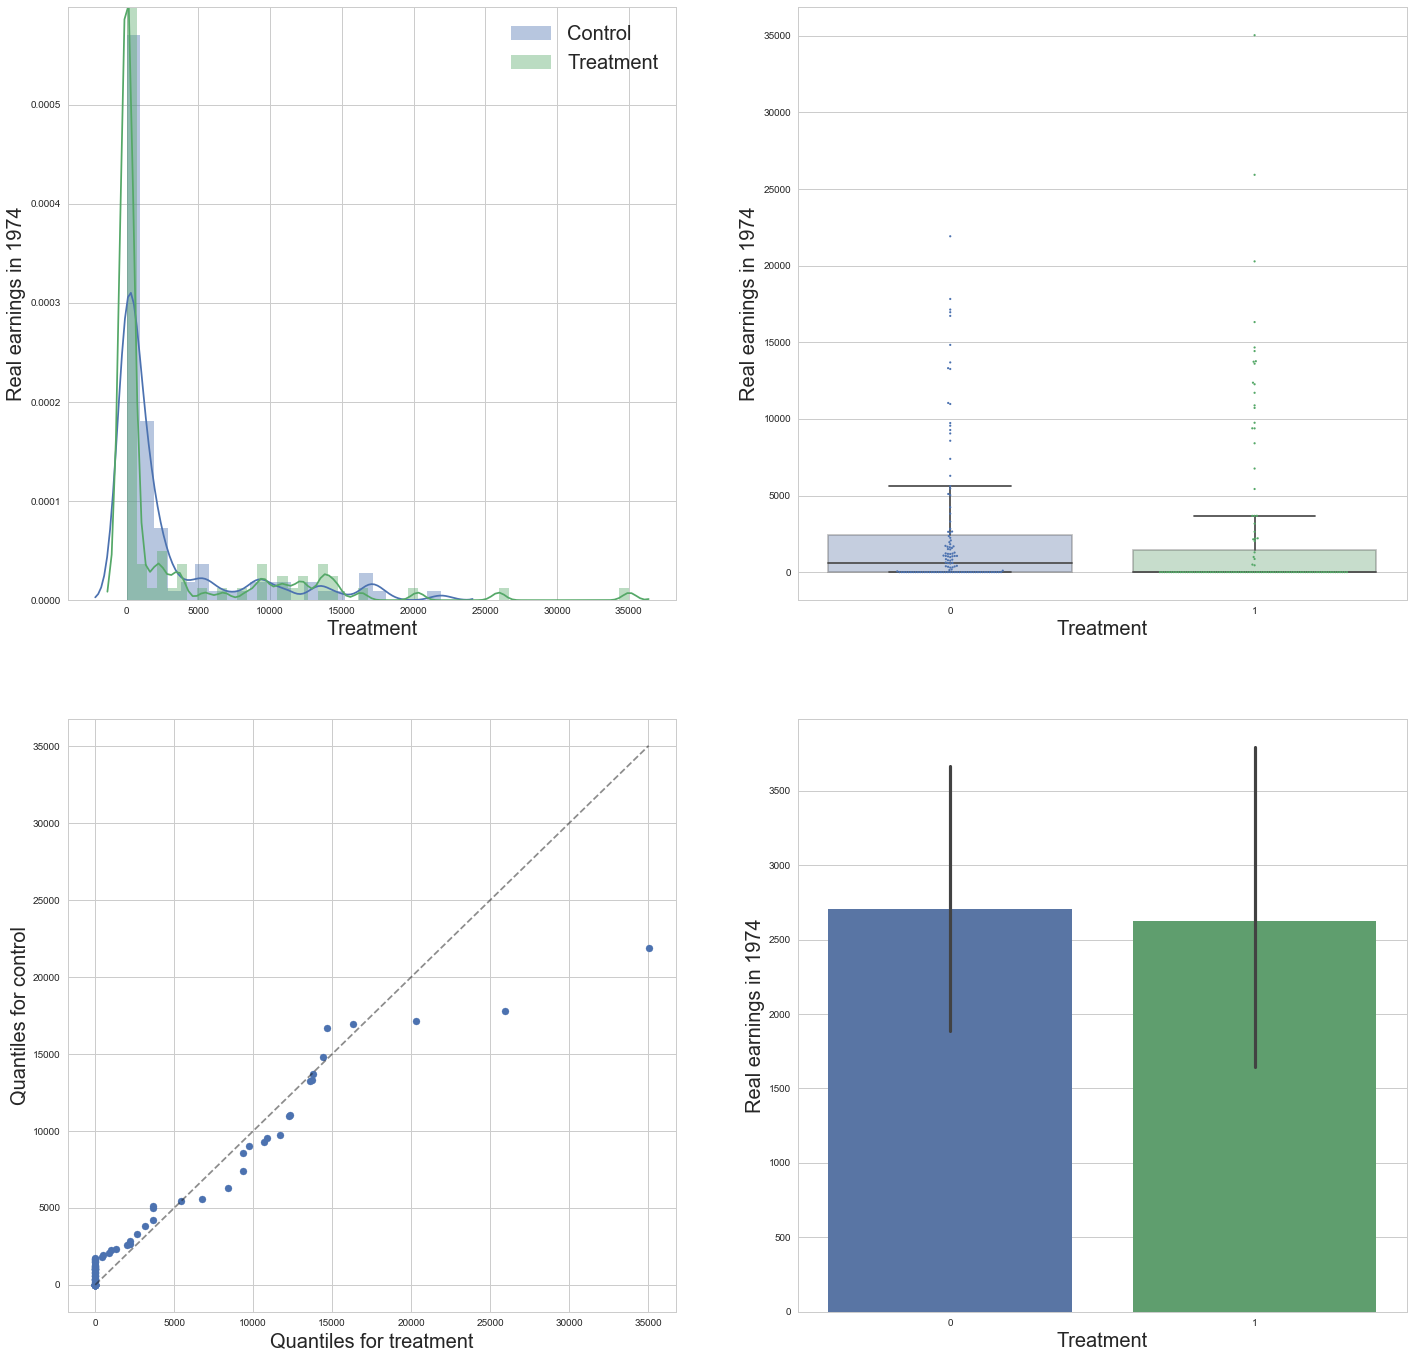

,Control,Treatment,Difference
count,116.000000,116.000000,0.000000
mean,2706.068372,2622.935259,83.133113
std,4734.558193,5850.207579,1115.649386
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,614.230150,0.000000,614.230150
75%,2407.449250,1475.600750,931.848500
max,21918.320000,35040.070000,13121.750000


In [92]:
describe_numerical_attribute(balanced_df_all, 're74', 'Real earnings in 1974')

Similarily as in the previous matching, the histogram, q-q plot and descriptive statistics clearly show that the distributions are quite comparable, and there are some individuals with earnings higher then average that account for the small differece in means.

# Real earnings in 1975

Real earnings in 1975 attribute analysis


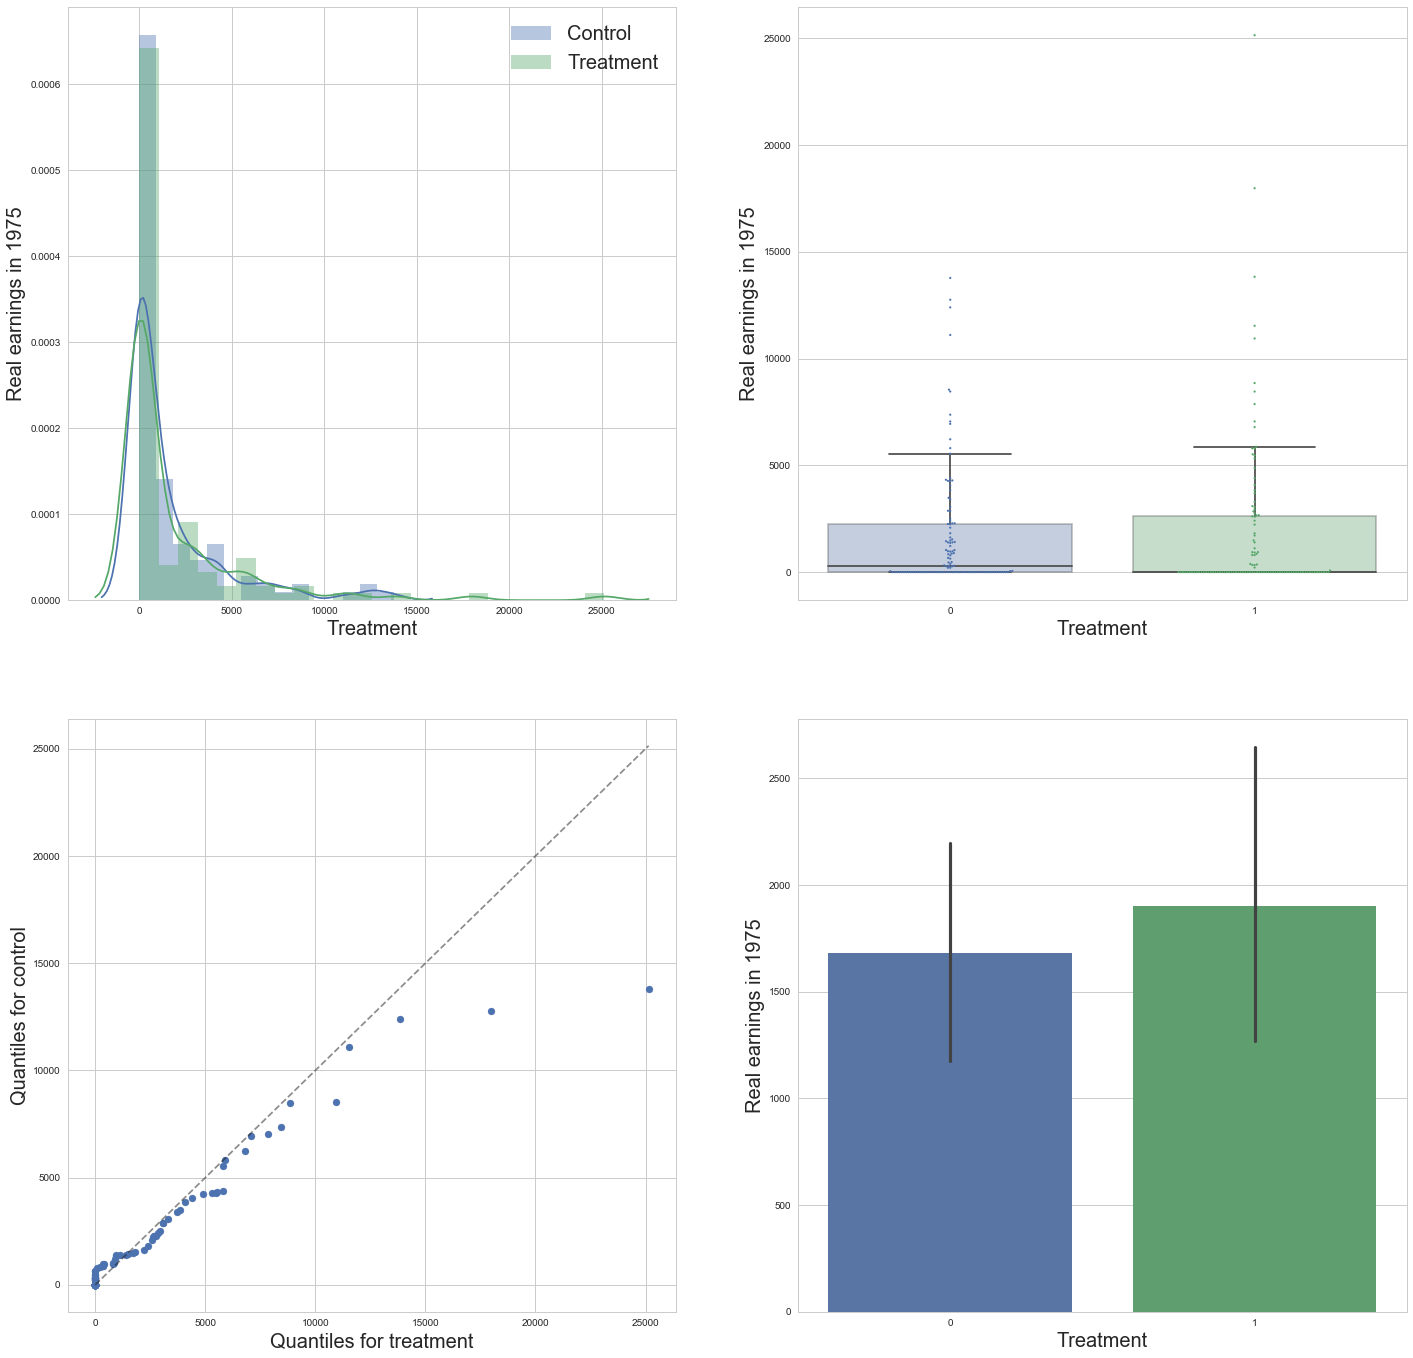

,Control,Treatment,Difference
count,116.000000,116.000000,0.000000
mean,1679.862711,1902.682456,222.819745
std,2865.638620,3816.255606,950.616986
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,287.346750,0.000000,287.346750
75%,2243.722000,2622.677750,378.955750
max,13776.530000,25142.240000,11365.710000


In [93]:
describe_numerical_attribute(balanced_df_all, 're75', 'Real earnings in 1975')

Again all the figures show that distirbutions are comparable

## Task 6. A less naive analysis

After the propensity score matching, we analyse the distribution of the post treatment earning.

Real earnings in 1978 attribute analysis


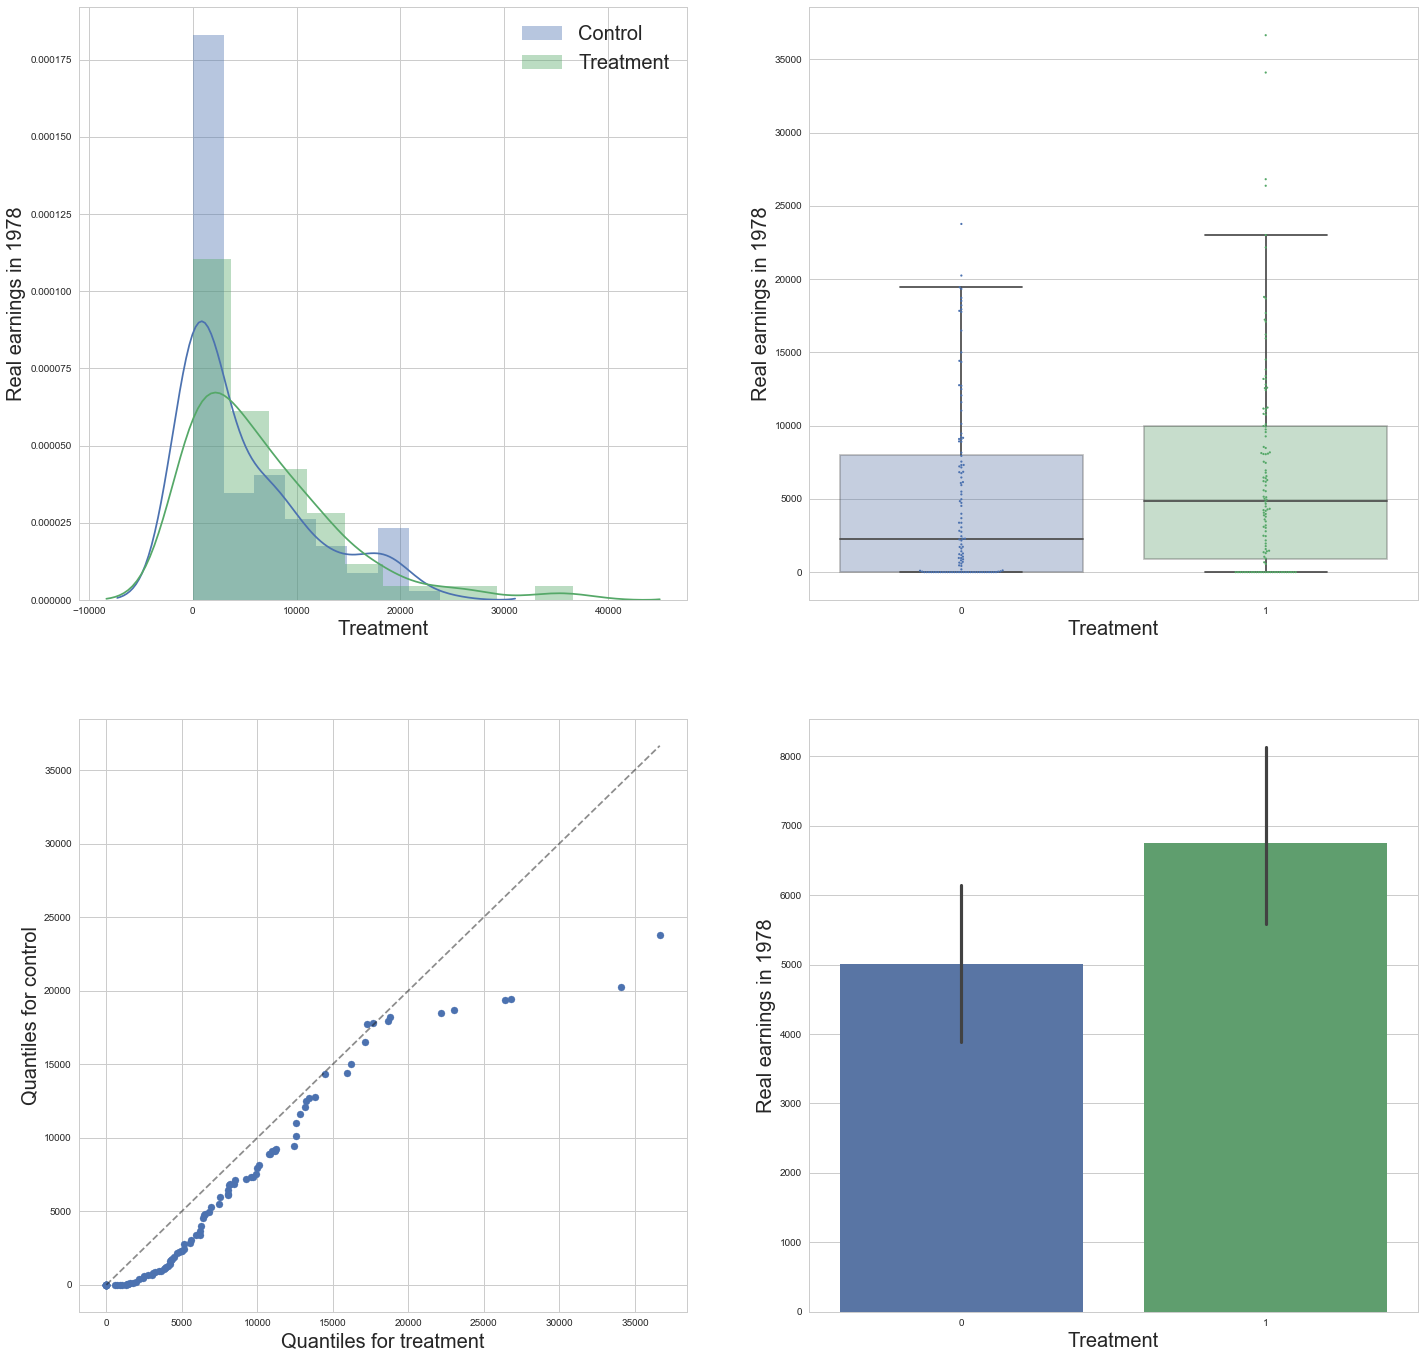

,Control,Treatment,Difference
count,116.000000,116.000000,0.000000
mean,5005.454826,6744.513572,1739.058746
std,6073.222260,7262.280884,1189.058624
min,0.000000,0.000000,0.000000
25%,0.000000,865.632250,865.632250
50%,2256.488500,4878.238000,2621.749500
75%,7988.959250,10001.218250,2012.259000
max,23764.800000,36646.950000,12882.150000


In [120]:
describe_numerical_attribute(balanced_df_all, 're78', 'Real earnings in 1978')

All of the figures, clearly favor the treated group. The difference in quartile's is the most evident, the median is more than 2 times higher in the treatment groop, but there is also a significant differenc in the 75% quartile as well as the maximum, but the mean is also higher.

Now we do perform some significance tests.

In [125]:
import scipy.stats as stats
control = balanced_df_all[balanced_df_all['treat'] == 0]
treatment = balanced_df_all[balanced_df_all['treat'] == 1]

In [128]:
s, p = stats.mannwhitneyu(control['re78'], treatment['re78'], alternative='less')
print("The Mann–Whitney U test reports a p-value of %.2f" % p)

The Mann–Whitney U test reports a p-value of 0.03


In [130]:
s, p = stats.ttest_ind(control['re78'], treatment['re78'], equal_var=False)
print("The independent T-test reports a p-value of %.2f" % p)

The independent T-test reports a p-value of 0.05


We support the claim made before with a <a href='https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test' >Mann-Whitney U test</a> stating that the earnings in the treatment group come from a distribution which is inherently higher valued than the earnings in the control group (the higher valued sample is not generated due to chance) with high significance ($p = 0.03$).

We support the claim made before with a independendent T-test stating that the earnings mean in the treatment group is higher than the mean in the control group, with significance ($p = 0.05$)

As a final conclusion we can state that the result after the propensity score matching, drastically changes and support the possitive effect of the training program.

<hr>

# Question 2 - Applied ML

### Abstract

In this task we were introduced with the problem of text classification. Given 18'846 text samples from different sources, we were asked to build a model which would correctly predict in which of the 20 possible classes the given input belongs to. For this purpose we converted the text samples into numerical vectors based on TF-IDF and obtained a transformed dataset of size $18'846\times173'762$.

The algorithm of choice for this task is random forests, which required grid searching the necessary parameters prior to training. The training, parameter tuning and evaluation steps were done using train, validation and test sets, respectively, following the holdout strategy with a 80-10-10 split.

The overall accuracy of the model on the test set is 84.62%, based on 64'476 of the most significant features or 37.1% of the total size of the feature space. The top 20 words that contribute the most to the classification are: <i>sale</i>, <i>dod</i>, <i>windows</i>, <i>car</i>, <i>re</i>, <i>clipper</i>, <i>of</i>, <i>bike</i>, <i>the</i>, <i>god</i>, <i>hockey</i>, <i>to</i>, <i>israel</i>, <i>is</i>, <i>encryption</i>, <i>space</i>, <i>lines</i>, <i>that</i>, <i>in</i> and <i>graphics</i>.

### Loading and analysing the data

Naturally, the first step is to load the dataset using `sklearn`. Instead of always fetching the data from the different sources, the method is caching it on a provided path. In our case, we pass the `data` folder as the place where the caching can be done.

In [94]:
news_raw = fetch_20newsgroups(data_home='./data', subset='all')

The data needed for the solution of the problem lies in the `data` and `target` attributes. Another useful variable is `target_names` and can be used to map the target attribute, which is the index of the category represented as an integer, to a more meaningful label.

First of all, let us examine the dimensionality of the data, to get a sense of the load we will be dealing with.

In [95]:
print(len(news_raw.data))
print(len(news_raw.target_names))

18846
20


There is a total of 18'846 texts that are classified into 20 possible categories or topics.

It would be much more convenient to work with the true class labels in their textual form instead of the indices that point to the array positions where they can be fetched.

In [96]:
# Make the class labels textual
class_lbl = []
for lbl_num in news_raw.target:
    # Map the label index to the label textual value
    class_lbl.append(news_raw.target_names[lbl_num])
class_lbl = np.array(class_lbl)

Let us visualise the distribution of the class labels for the dataset.

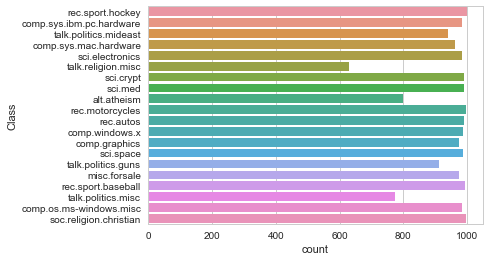

In [97]:
class_df = pd.DataFrame(class_lbl, columns=['Class'])
sns.countplot(y="Class", data=class_df)
plt.show()

Based on the above plot which represents the data samples count for each class label, we don't deem necessary to introduce weights to balance the classes or introduce any additional techniques to cope with that issue, since all the classes are pretty balanced (with a few exceptions, but they are not extreme).

### Creating the feature vectors

The next step before training a classifier is to create a numerical vector representation for each text sample. This is easily achieved using tf-idf (term frequency-inverse document frequency), which counts the number of times a word appears in the text, but normalises (scales) that count with the measure of how many dataset texts it appears in. This will help uncover the prominence of a word for a particular text sample.

A word is only useful for the purpose of classification if it is very frequent in a particular text sample from a certain category, but doesn't appear often in other texts labelled differently. And that is exactly what tf-idf measures.

In [98]:
vectorizer = TfidfVectorizer()
doc_term_matrix = vectorizer.fit_transform(news_raw.data)
doc_term_matrix.shape

(18846, 173762)

The resulting dataset now has 18846 text samples, each being a 173762-dimensional numeric vector. Each dimension corresponds to a particular word from the corpus formed by the entire news dataset.

In [99]:
print(doc_term_matrix.nnz)  # number of non-zero entries in the matrix
print(doc_term_matrix.nnz / (doc_term_matrix.shape[0] * doc_term_matrix.shape[1]) * 100)  # percentage of non-zero entries

2952534
0.09016145549471162


Naturally, the result is a very sparse matrix (with many zero values). Only 2'952'534 out of 3'274'718'652 entries in the sparse matrix are non-zero, which is a percentage of approximately 0.09.

### Setting the evaluation prerequisites

Having finished with the pre-processing and the exploratory analysis of the data, the logical next step to discuss is a way to train and evaluate the model. For tackling the given problem, we propose to use the holdout strategy according to which 80% of the dataset will be used to train the model, 10% will go into the validation set that will be helpful when tweaking and hypertuning the parameters of the model, and the final 10% are left for the final evaluation of the model.

In order to get the highest amount of flexibility in partitioning the dataset, we implement our own function for the holdout method.

In [100]:
def split_dataset(dataset, labels, train_percent=0.8, validation_percent=0.1, test_percent=0.1):
    num_samples, num_features = dataset.shape
    
    # A total round error of 2 is possible in favour of the test set, 
    # i.e. the test set might have 2 more samples than the requested percentage
    train_number = int(num_samples * train_percent)
    validation_number = int(num_samples * validation_percent)
    test_number = int(num_samples * test_percent)
    
    # Make a random permutation of the indices which would go in each set
    perm = np.random.permutation(num_samples)

    # Split the indices for the rows that would be included in each set
    train_set_idx = perm[:train_number]
    validation_set_idx = perm[train_number:(train_number + validation_number)]
    test_set_idx = perm[(train_number + validation_number):]

    # Create the actual sets
    train_set = dataset[train_set_idx, :]
    validation_set = dataset[validation_set_idx, :]
    test_set = dataset[test_set_idx, :]
    
    # Split the labels accordingly
    train_set_lbls = labels[train_set_idx]
    validation_set_lbls = labels[validation_set_idx]
    test_set_lbls = labels[test_set_idx]
    
    return train_set, train_set_lbls, validation_set, validation_set_lbls, test_set, test_set_lbls
    
train, train_lbl, validation, validation_lbl, test, test_lbl = split_dataset(doc_term_matrix, class_lbl)

In [101]:
print(train.shape, train_lbl.shape)
print(validation.shape, validation_lbl.shape)
print(test.shape, test_lbl.shape)

(15076, 173762) (15076,)
(1884, 173762) (1884,)
(1886, 173762) (1886,)


The above output shows the dimensions of each set, i.e. the number of samples that fall into each one of them.

### Best parameters search

Finally, we reached the point where everything is ready to start with the classificator training process. Since random forests depend on a few parameters, namely the number of trees that will be trained and the maximal depth of each tree, we need to perform a grid search over a range of different values to be able to make an informed decision which ones to set in order to get the best classifier.

The number of trees lower bound is set to 10, which is the default value that the `RandomForestClassifier` method will take, and the upper bound is 160 (inclusive). This assures a large enough range that will be informative enough as to whether we need to extend the search to 170 and over or this will suffice and we will get the optimal parameter within this given range.

Training a random forest once, without setting the `max_depth` parameter resulted in trees whose depth ranged from 200-300, therefore the grid search values was chosen to range from 150 to 300 (inclusive). 

Of course, the range values are based on intuition, hunches and reasonable guesses. The analysis that follows is crucial to provide intel which parameter values are the ones worth to be taken into consideration.

The evaluation for the classifier performance is based on the accuracy measure obtained on the validation dataset.

In [102]:
# Grid search for the best parameters
evaluation = []
for num_trees in range(10, 170, 10):
    print("Random forest with:", num_trees, "trees")
    for depth in range(150, 310, 10):
        if depth % 50 == 0:
            print("----- depth:", depth)
            
        # n_jobs = -1 sets the number of parallel threads to the number of cores available
        clf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, max_depth=depth)
        # train the classifier
        clf.fit(train, train_lbl)
        # create predictions on the validation test
        validation_predicted_lbl = clf.predict(validation)
        # compute accuracy value
        accuracy = metrics.accuracy_score(validation_lbl, validation_predicted_lbl)
        
        evaluation.append([num_trees, depth, accuracy])
        
grid_search_results = pd.DataFrame(np.array(evaluation), columns=['Number of trees', 'Max depth', 'Accuracy'])

Random forest with: 10 trees
----- depth: 150
----- depth: 200
----- depth: 250
----- depth: 300
Random forest with: 20 trees
----- depth: 150
----- depth: 200
----- depth: 250
----- depth: 300
Random forest with: 30 trees
----- depth: 150
----- depth: 200
----- depth: 250
----- depth: 300
Random forest with: 40 trees
----- depth: 150
----- depth: 200
----- depth: 250
----- depth: 300
Random forest with: 50 trees
----- depth: 150
----- depth: 200
----- depth: 250
----- depth: 300
Random forest with: 60 trees
----- depth: 150
----- depth: 200
----- depth: 250
----- depth: 300
Random forest with: 70 trees
----- depth: 150
----- depth: 200
----- depth: 250
----- depth: 300
Random forest with: 80 trees
----- depth: 150
----- depth: 200
----- depth: 250
----- depth: 300
Random forest with: 90 trees
----- depth: 150
----- depth: 200
----- depth: 250
----- depth: 300
Random forest with: 100 trees
----- depth: 150
----- depth: 200
----- depth: 250
----- depth: 300
Random forest with: 110 trees

At this point, it would be a good idea to plot the obtained results from the performed grid search, just to get an intuition of how the two classifier parameters: number of trees and maximum depth, affect the overall accuracy of the trained model.

Since there are only 3 variables in question, all of which numerical, they can be easily represented in 3D space. A surface plot showing accuracy as a bivariate function of the number of trees and maximum depth is the most suitable.

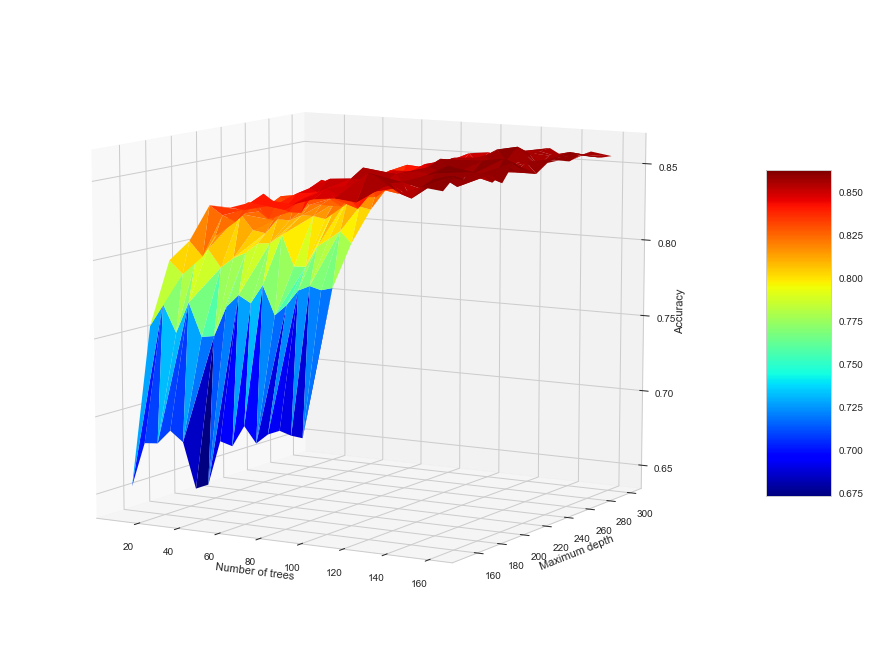

In [103]:
# Create the plot
fig = plt.figure(figsize=(16, 12))
ax = fig.gca(projection='3d')
 
# Maps values to colours
surf = ax.plot_trisurf(grid_search_results['Number of trees'], grid_search_results['Max depth'], grid_search_results['Accuracy'], cmap=plt.cm.jet, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)

# Rotate the plot for better visualisation
ax.view_init(10, 300)

# Label the axes
ax.set_xlabel('Number of trees')
ax.set_ylabel('Maximum depth')
ax.set_zlabel('Accuracy')
plt.show()

The above figure is a surface plot typically used to visualise multivariate data. In this context, it shows the accuracy values of the random forest algorithm for different model parameters obtained by grid search. The tuned parameters are: number of trees and maximum tree depth. We experimented with a range of the number of trees in the random forest from 10 to 160 (inclusive), with a step size of 10. The range for the trees' maximum depth is from 150-300 (inclusive), again using a step size of 10. The plot shows a very steep rise in the accuracy of the classifier once the number of trees in the forest starts increasing from 10, but then there is an evident plateau once the value surpasses 90.

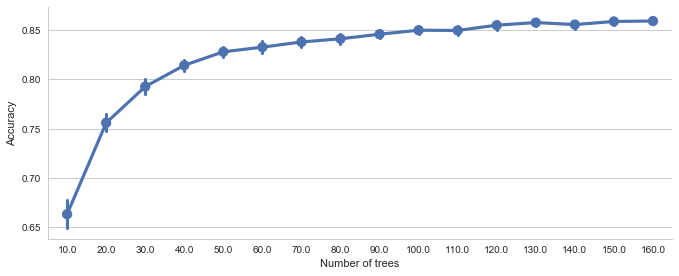

In [104]:
sns.factorplot(x="Number of trees", y="Accuracy", data=grid_search_results, ci='sd', size=4, aspect=2.4)
plt.show()

The line chart plot automatically aggregates the data by grouping the values according to the number of trees and computing the average accuracy over the range of tree maximum depth values. The plot also shows the standard deviation for each point as a line which eventually becomes barely visible as the values get much closer to the mean.

Here it is even clearer that there isn't a big improvement, i.e. accuracy gain, as the number of trees in the random forest increases above 90. Yes, the absolute values for the accuracy may vary depending on the choice of the validation set, but we expect that the trend for accuracy gain will remain unchanged. Therefore, we're not going to explore further values for the number of trees and we'll just take the one that, on average, provides maximum accuracy based the data we already have, which is 150.

The following plot shows the accuracy in terms of the maximum depth for the case when the random forest consists of 150 trees.

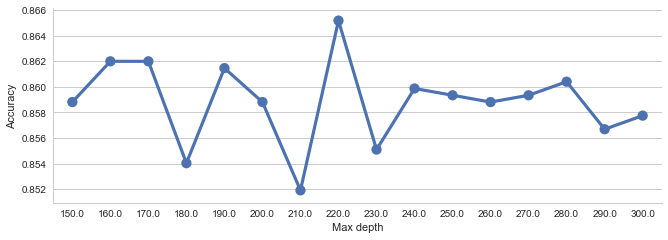

In [105]:
sns.factorplot(x="Max depth", y="Accuracy", data=grid_search_results[grid_search_results['Number of trees'] == 150], size=3.5, aspect=2.7)
plt.show()

According to the plot, it is justified to say that a reasonable value for the `max_depth` parameter is 180.

Therefore, following the analysis made in the previous steps of the task, which included a grid search over a predefined range of parameter values and analysis of the behaviour of the model in terms of accuracy over a validation set, the conclusion is that it should be proceeded with a random forest of 150 trees, each one with a maximum depth of 180. These are the parameters that will be used for the final solution.

### Building a classifier with the best parameters

In [106]:
# n_jobs = -1 sets the number of parallel threads to the number of cores available
clf = RandomForestClassifier(n_estimators=150, max_depth=180, n_jobs=-1)

In [107]:
clf.fit(train, train_lbl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=180, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [108]:
test_predicted_lbl = clf.predict(test)

Once the class labels for the test set are predicted, the actual and the predicted labels can be best visualised using a confusion matrix. That will provide insight of how good the classifier is. Of course, having 20 different class labels, it becomes fairly difficult to interpret the numbers without spending some time and attention. Therefore, the confusion matrix is also given in a graphical variant that is more human-perceptible and significantly easier to comprehend.

In [109]:
confusion_matrix = pd.crosstab(test_lbl, test_predicted_lbl, rownames=['Actual Class'], colnames=['Predicted Class'])
confusion_matrix

Predicted Class,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
Actual Class,,,,,,,,,,,,,,,,,,,,
alt.atheism,68,0,0,0,0,0,1,1,0,0,0,0,1,1,1,8,0,0,0,3
comp.graphics,0,69,5,2,0,10,1,0,0,0,0,0,1,0,2,0,0,0,0,0
comp.os.ms-windows.misc,0,3,76,3,0,4,1,0,0,0,0,0,3,0,0,0,0,0,0,0
comp.sys.ibm.pc.hardware,0,5,2,77,8,6,4,0,0,0,1,1,2,0,1,1,0,0,0,0
comp.sys.mac.hardware,0,3,4,7,78,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0
comp.windows.x,0,3,3,1,1,74,0,0,0,0,0,0,0,0,1,0,0,0,0,0
misc.forsale,0,1,0,3,3,0,93,2,0,0,1,0,0,0,1,0,0,0,0,0
rec.autos,0,0,1,0,0,0,5,92,4,0,0,0,1,1,0,0,1,0,0,0
rec.motorcycles,0,0,0,0,0,0,2,2,92,0,1,0,1,0,0,0,0,0,0,0


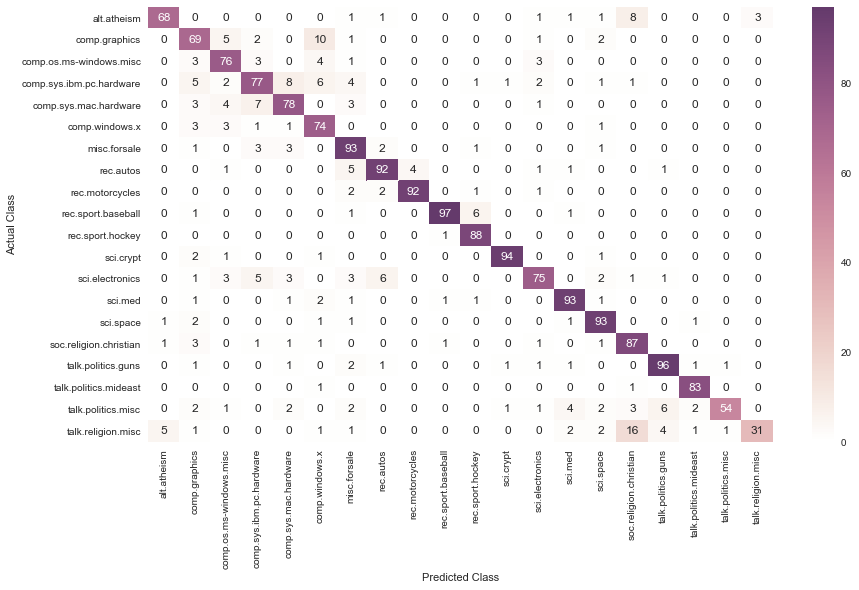

In [110]:
colour_palette = sns.cubehelix_palette(light=1, dark=0.3, as_cmap=True)
plt.figure(figsize = (14, 8))
sns.heatmap(confusion_matrix, cmap=colour_palette, annot=True)
plt.show()

An interesting observation to make based on the confusion matrix is that most of the misclassifications occur for classes which are very similar, sometimes even overlapping one might say. Let's take `talk.religion.misc` and `soc.religion.christian` as an example. It's not just that the topics are not disjoint, but moreover the former might be considered a superset of the latter. Same with `talk.politics.guns` and `talk.politics.misc`.

Other more significant misclassifications occur due to the fact that the texts only differ in the subgroups, so they contain similar language, terms and jargon, which makes it very difficult to tell them apart. Handling these ambiguous cases greatly depends on the use-case. We cannot say this is bad classification a-priori. For example, if the use-case is a recommendation system which suggests news or threads to a user, then it might not be completely undesirable to show texts from a very similar category, even though theoretically it doesn't belong in the same class.

### Discussion of the different evaluation metrics

To better evaluate the classifier, we used the well-known F-measure metric as addition to the classifier's accuracy. The F-measure combines the precision and recall scores using the harmonic mean. The formulas for each evaluation measure is given below. 

\begin{equation}
    \pi=\frac{TP}{TP+FP} \qquad
    \rho=\frac{TP}{TP+FN} \qquad
    F=\frac{2\pi\rho}{\pi+\rho}
\end{equation}

In the above equations `TP` = <b>T</b>rue <b>P</b>ositive, `TN` = <b>T</b>rue <b>N</b>egative, `FP` = <b>F</b>alse <b>P</b>ositive and `FN` = <b>F</b>alse <b>N</b>egative. As these metrics were discussed in class, there shouldn't be any necessity to go over their meaning once again here.

What might be important to mention is the not so straight-forward way of computing the precision and recall measure values in the case of multiclass classification. There exist multiple ways of doing so.

1. <i>micro</i>: `F-measure` is computed globally over all category decisions by counting the total true positives, false negatives and false positives. $ \rho $ and $ \pi $ are obtained by summing over all individual decisions. Micro-averaged F-measure gives equal weight to each document and is therefore considered as an average over all the document/category pairs.
2. <i>macro</i>: F-measure is computed locally over each category first and then the unweighted mean over all categories is taken. $ \rho $ and $ \pi $ are computed for each category. This does not take label imbalance into account, but this is not so important in this particular case as the classes are well balanced in the first place.

We provide both measures for the test dataset in order to be more informative.

In [111]:
print('===== accuracy =====')
print(metrics.accuracy_score(test_lbl, test_predicted_lbl))

===== accuracy =====
0.853658536585


In [112]:
print('===== precision =====')
print('- micro:', metrics.precision_score(test_lbl, test_predicted_lbl, average='micro'))
print('- macro:', metrics.precision_score(test_lbl, test_predicted_lbl, average='macro'))

===== precision =====
- micro: 0.853658536585
- macro: 0.860834248239


In [113]:
print('===== recall =====')
print('- micro:', metrics.recall_score(test_lbl, test_predicted_lbl, average='micro'))
print('- macro:', metrics.recall_score(test_lbl, test_predicted_lbl, average='macro'))

===== recall =====
- micro: 0.853658536585
- macro: 0.846598378828


In [114]:
print('===== F-measure =====')
print('- micro:', metrics.f1_score(test_lbl, test_predicted_lbl, average='micro'))
print('- macro:', metrics.f1_score(test_lbl, test_predicted_lbl, average='macro'))

===== F-measure =====
- micro: 0.853658536585
- macro: 0.847312741272


### Discovering the most significant words

One perk of using random forests is that it enables us to see which were the most valuable features the algorithm bases its decisions on. The classifier itself gives access to a list of feature importance values that can be merged with the tf-idf vectorizer feature names, which provide a mapping from coordinate position to the actual word.

The 50 most important words on which the text classification is done are shown as a dataframe in the output below.

In [115]:
feature_importance = pd.DataFrame(clf.feature_importances_, columns=['Significance'])  # Create a dataframe
feature_importance['Word'] = vectorizer.get_feature_names()  # Map the word to its classifier importance value
feature_importance.sort_values('Significance', ascending=False).head(50)  # Top 50 most significant words

,Significance,Word
139570,0.004571,sale
165812,0.004298,windows
65684,0.003548,dod
52100,0.003336,car
46061,0.003312,bike
152603,0.002930,the
119845,0.002890,of
133530,0.002797,re
55485,0.002671,clipper
89701,0.002634,in


It would be interesting to see how many features were used at all in the decision making process. The following lines show that 109'286 out of the 173'762 have zero significance, which means the classification is made based on 37.1% of the features.

In [116]:
(1 - feature_importance[feature_importance['Significance'] == 0].shape[0] / feature_importance.shape[0]) * 100

37.12664449074021

In [117]:
feature_importance_nz = feature_importance[feature_importance['Significance'] != 0]
feature_importance_nz.shape

(64512, 2)

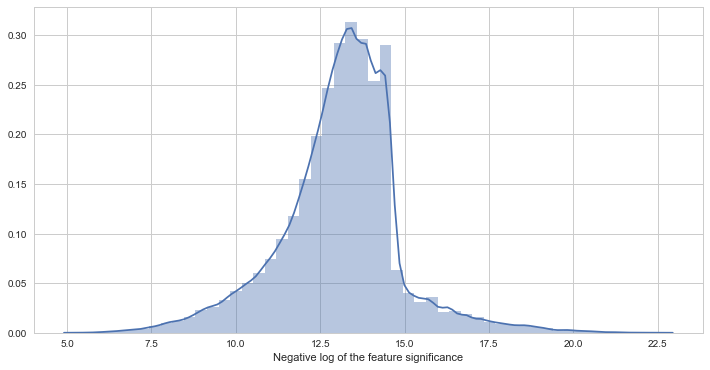

In [118]:
plt.figure(figsize = (12, 6))
sns.distplot(-np.log(feature_importance_nz['Significance']), axlabel="Negative log of the feature significance")
plt.show()

Since the distribution of the most important words is highly skewed, as the majority of them have a very small significance value, it makes more sense to represent them on a negative log-scale rather than one very tall column. Also, the significance values which were initially zero are removed, because they don't really contribute to the process.

It's interesting to notice how among the 50 most significant words there are many stop-words that the algorithm found useful in determining the text class and yet the classification it makes is fairly good. The only seen issues happen when the classes are very similar to eachother, overlap or belong to the same supergroup. As discussed in the previous sections, this might not always be considered a problem because it is use-case dependent.